In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from analyze_utilities import *
from dataset_utilities import create_cifar10_dataloaders
import pandas as pd
import copy

def load_dict_from_file_list(files):
    result_dict = {}
    for file in files:
        with open(file) as data_file:    
            result_dict.update(json.load(data_file)) 
    return result_dict

# Load Results

In [5]:
#------
# Emipircal Risk Minimization (ERM)
files = ['../output/ERM_results_20180813_204946/results_ERM_20180813_204946.json'] # 0-10,000
results_dict_ERM = load_dict_from_file_list(files)
print('NML: loaded %d keys' % len(results_dict_ERM))

#------
# CIFAR 10 : Normalized Maximum Likelihood with test samples from CIFAR 10    
files = ['../output/NML_results_20180820_084237/results_NML_20180820_084237.json', # 000-099
         '../output/NML_results_20180815_135021/results_NML_20180815_135021.json', # 100-199
         '../output/NML_results_20180815_134312/results_NML_20180815_134312.json', # 200-299
         '../output/NML_results_20180815_134318/results_NML_20180815_134318.json', # 300-399
         '../output/NML_results_20180815_134413/results_NML_20180815_134413.json', # 400-499
         '../output/NML_results_20180815_134420/results_NML_20180815_134420.json', # 500-599
         '../output/NML_results_20180815_134427/results_NML_20180815_134427.json', # 600-699
         '../output/NML_results_20180815_134449/results_NML_20180815_134449.json', # 700-799
         '../output/NML_results_20180815_134501/results_NML_20180815_134501.json', # 800-899
         '../output/NML_results_20180815_134527/results_NML_20180815_134527.json'] # 900-999
results_dict_NML = load_dict_from_file_list(files)
print('NML: loaded %d keys' % len(results_dict_NML))

#------
# CIFAR 100: Normalized Maximum Likelihood with Cifar 10 trainset and test samples from CIFAR 100
files = ['../output/OutOfDist_CIFR100_results_20180813_153916/results_OutOfDist_CIFR100_20180813_153916.json', # 00-24
         '../output/OutOfDist_CIFR100_results_20180814_150859/results_OutOfDist_CIFR100_20180814_150859.json'] # 25-99
results_dict_CIFAR100 = load_dict_from_file_list(files)
print('CIFAR100: loaded %d keys' % len(results_dict_CIFAR100))

#------
# Noise: Normalized Maximum Likelihood with Cifar 10 trainset and Noise images test samples
files = ['../output/OutOfDist_Noise_results_20180813_153950/results_OutOfDist_Noise_20180813_153950.json',  # 00-24
         '../output/OutOfDist_Noise_results_20180814_150915/results_OutOfDist_Noise_20180814_150915.json' ] # 25-100
results_dict_Noise = load_dict_from_file_list(files)
print('Noise: loaded %d keys' % len(results_dict_Noise))

NML: loaded 10000 keys
NML: loaded 1000 keys
CIFAR100: loaded 100 keys
Noise: loaded 100 keys


# Visualize Out of Distribution
Plot histogram of the normalization factor from based on 
1. cifar10 dataset
2. cifar 100 dataset
3. Noise images

In [4]:
# Extract and plot normalization factor
_, normalization_factor_CIFAR10_list, _, _, _ = get_NML_log_loss_from_dict(results_dict_NML)
_, normalization_factor_CIFAR100_list, _, _, _  = get_NML_log_loss_from_dict(results_dict_CIFAR100)
_, normalization_factor_Noise_list, _, _, _ = get_NML_log_loss_from_dict(results_dict_Noise)

log_normalization_factor_CIFAR10_list = np.log10(normalization_factor_CIFAR10_list)
log_normalization_factor_CIFAR100_list = np.log10(normalization_factor_CIFAR100_list)
log_normalization_factor_Noise_list = np.log10(normalization_factor_Noise_list).tolist()

# Print the mean
print('log10(NormalizationFactor): [cifar10 cifar100 Noise]=[%f %f %f] ' % 
      (np.mean(log_normalization_factor_CIFAR10_list), 
       np.mean(log_normalization_factor_CIFAR100_list), 
       np.mean(log_normalization_factor_Noise_list)))

log10(NormalizationFactor): [cifar10 cifar100 Noise]=[0.227915 0.540402 0.743275] 


<Figure size 432x288 with 0 Axes>

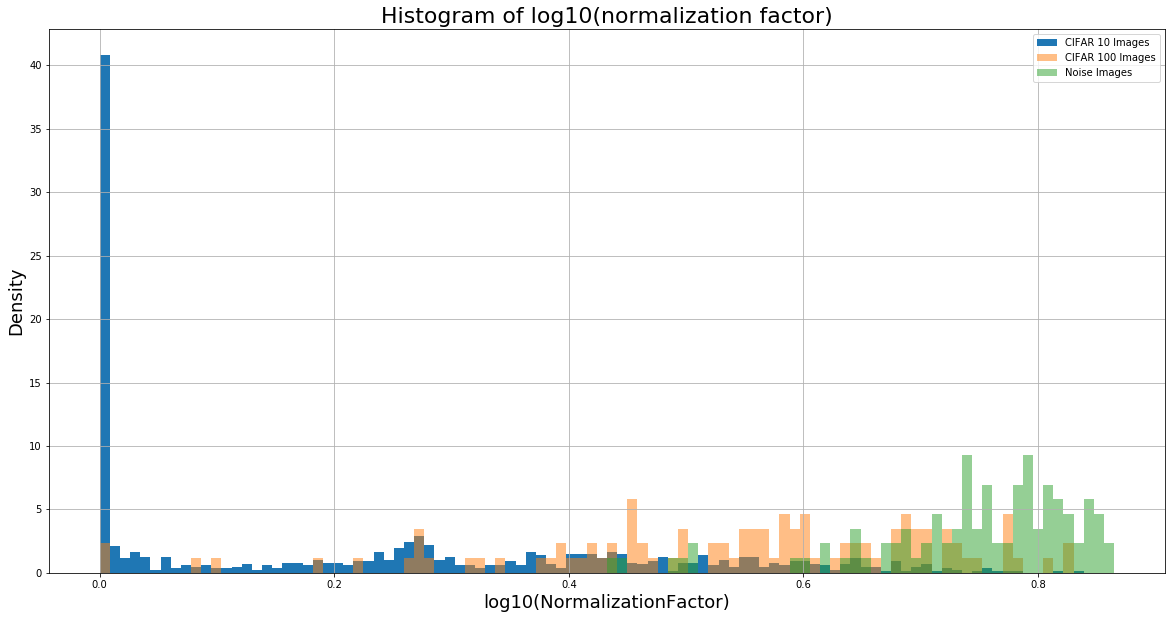

In [5]:
# Initalize joint bins
bins = 100
n, bins, patches = plt.hist([log_normalization_factor_CIFAR10_list,
                             log_normalization_factor_CIFAR100_list,
                             log_normalization_factor_Noise_list], alpha=1, density=True,
                            label=['CIFAR 10 Image', 'CIFAR 100 Image', 'Noise Image'], bins=bins)
plt.gcf().clear()

# Plot
plt.figure(figsize=(20,10))
plt.hist(log_normalization_factor_CIFAR10_list, alpha=1, density=True, label='CIFAR 10 Images', bins=bins)
plt.hist(log_normalization_factor_CIFAR100_list, alpha=0.5, density=True, label='CIFAR 100 Images', bins=bins)
plt.hist(log_normalization_factor_Noise_list, alpha=0.5, density=True, label='Noise Images', bins=bins)

plt.ylabel('Density', fontsize=18)
plt.xlabel('log10(NormalizationFactor)', fontsize=18)
plt.title('Histogram of log10(normalization factor)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

# Visualize the Loss of the Different Methods
1. Empiriical Risk Minimization (ERM)
2. Normalized Maximum Likelihood (NML)
3. Jinni- model which was trained real label of the test sample

In [8]:
# Extract from dict
loss_NML_list, normalization_factor_NML_list, acc_NML, is_correct_NML_list, _ = get_NML_log_loss_from_dict(results_dict_NML)
loss_ERM_list, acc_ERM, is_correct_ERM_list = get_ERM_log_loss_from_dict(results_dict_NML)
loss_Jinni_list, acc_Jinni = get_jinni_log_loss_from_dict(results_dict_NML)

# Print acc and mean loss
statistics = {'Jinni': pd.Series([acc_Jinni,  np.mean(loss_Jinni_list), np.std(loss_Jinni_list)], 
                                 index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)']),
              'NML' : pd.Series([acc_NML,  np.mean(loss_NML_list), np.std(loss_NML_list)],
                                index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)']),
              'ERM' :pd.Series([acc_ERM,  np.mean(loss_ERM_list), np.std(loss_ERM_list)],
                               index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)'])}
print(pd.DataFrame(statistics).to_string())

                      Jinni       NML       ERM
Acc                0.993000  0.913000  0.920000
Mean Loss (log10)  0.015735  0.243650  0.202926
Std Loss (log10)   0.125907  0.273949  0.866917


<Figure size 432x288 with 0 Axes>

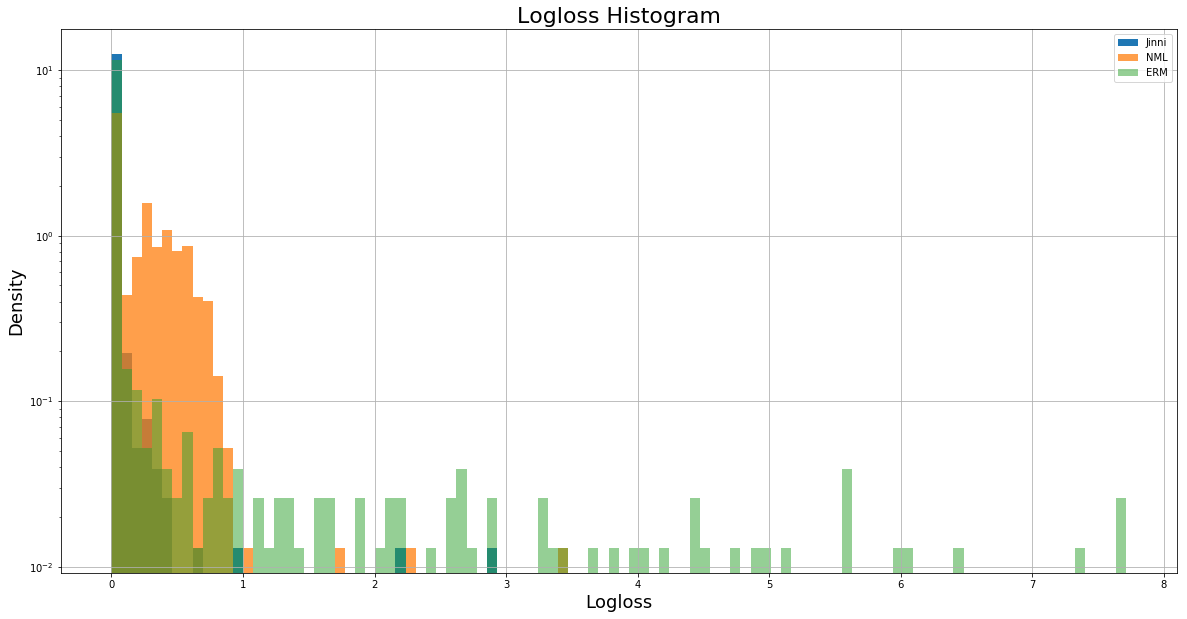

In [6]:
# Initalize joint bins
bins = 100
n, bins, patches = plt.hist([loss_NML_list, loss_Jinni_list, loss_ERM_list], bins=bins, alpha=1, label=['NML', 'Jinni', 'ERM'], density=True)
plt.gcf().clear()

# Plot
plt.figure(figsize=(20,10))
plt.hist(loss_Jinni_list, bins=bins, alpha=1, label='Jinni', density=True)
plt.hist(loss_NML_list, bins=bins, alpha=0.75, label='NML', density=True)
plt.hist(loss_ERM_list, bins=bins, alpha=0.5, label='ERM', density=True)
plt.ylabel('Density', fontsize=18)
plt.xlabel('Logloss', fontsize=18)
plt.title('Logloss Histogram', fontsize=22)
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

In [7]:
#  Construct best loss based on normalization factor
log10_normalization_factor_list = np.log10(normalization_factor_NML_list)
statistics = {'Jinni': pd.Series(loss_Jinni_list, index=log10_normalization_factor_list),
              'NML' : pd.Series(loss_NML_list, index=log10_normalization_factor_list),
              'ERM' :pd.Series(loss_ERM_list, index=log10_normalization_factor_list),
              'NML_is_true' :pd.Series(is_correct_NML_list, index=log10_normalization_factor_list)}
df = pd.DataFrame(statistics)
df = df.sort_index()

threshold_list = np.linspace(0,1,99)
loss_list = []
acc_list = []
acc_size_list = []
nml_solo_list = []
for threshold in threshold_list:
    
    # loss: erm and nml
    loss = np.concatenate(( df[df.index<= threshold]['ERM'].values, df[df.index>  threshold]['NML'].values)).mean()
    loss_list.append(loss)
    
    # loss: erm and nml
    loss_nml_solo = df[df.index<= threshold]['NML'].values.mean()
    nml_solo_list.append(loss_nml_solo)
    
    # Acc
    is_true_values =  df[df.index<= threshold]['NML_is_true'].values.astype(int)
    acc = is_true_values.mean()
    acc_list.append(acc)
    
    acc_size = is_true_values.shape[0] / float(df['NML_is_true'].values.shape[0])
    acc_size_list.append(acc_size)  

/Users/kobibi/anaconda3/envs/pt36/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: Mean of empty slice.
/Users/kobibi/anaconda3/envs/pt36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kobibi/anaconda3/envs/pt36/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: Mean of empty slice.
/Users/kobibi/anaconda3/envs/pt36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


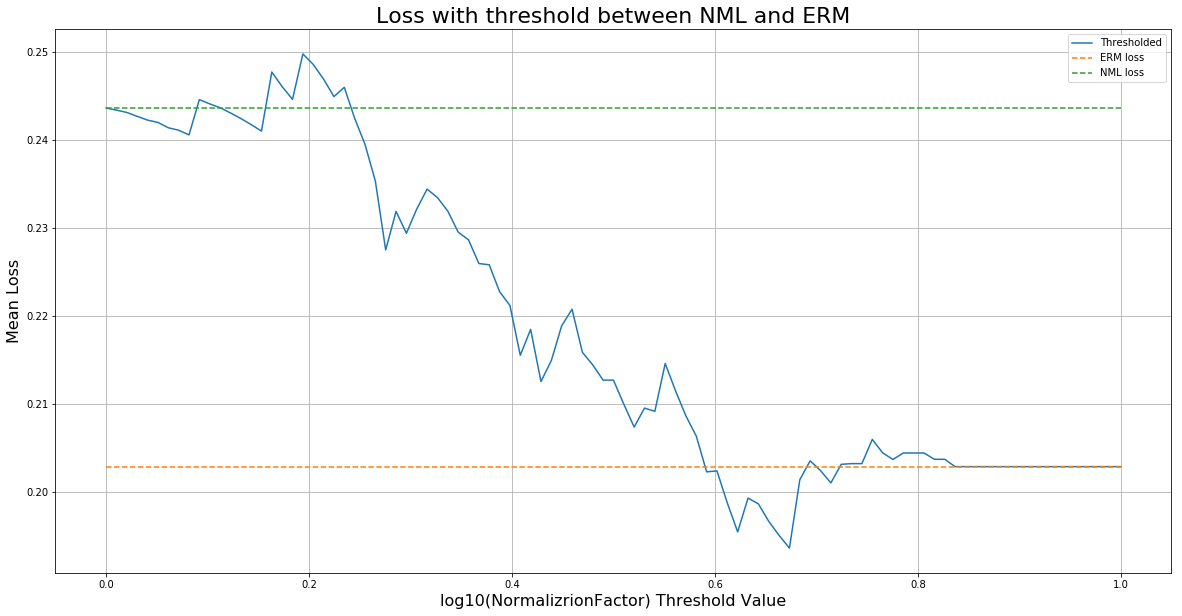

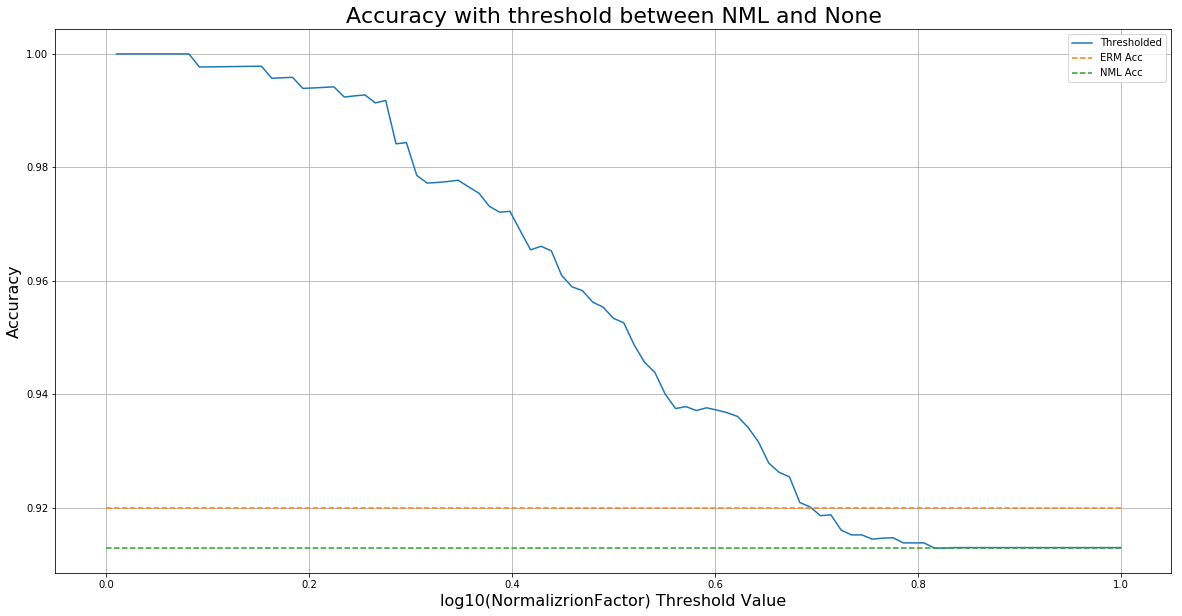

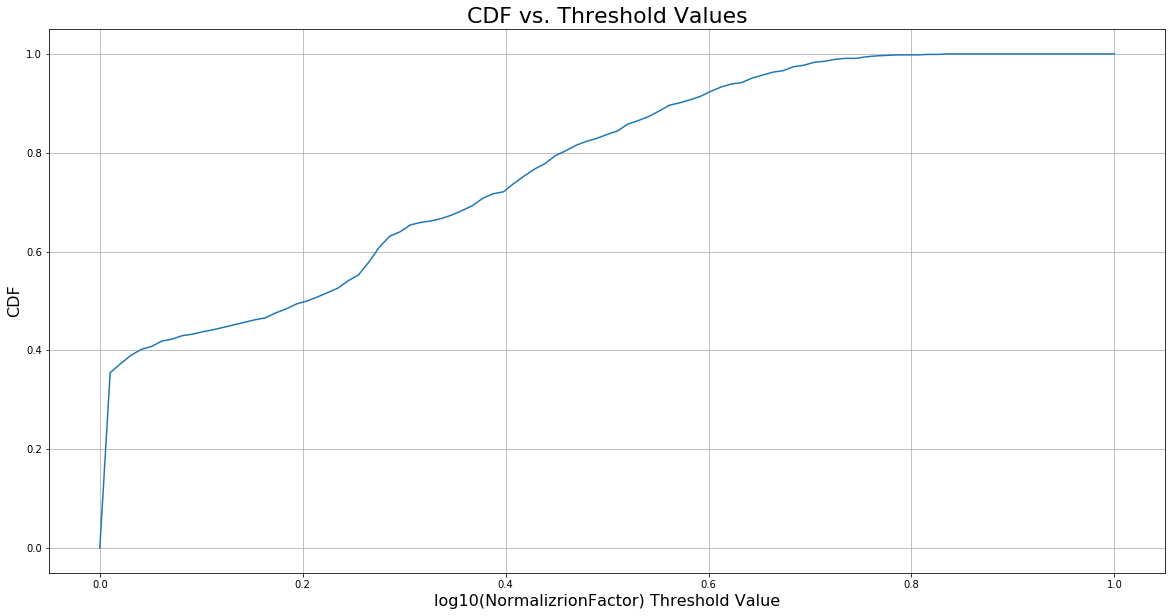

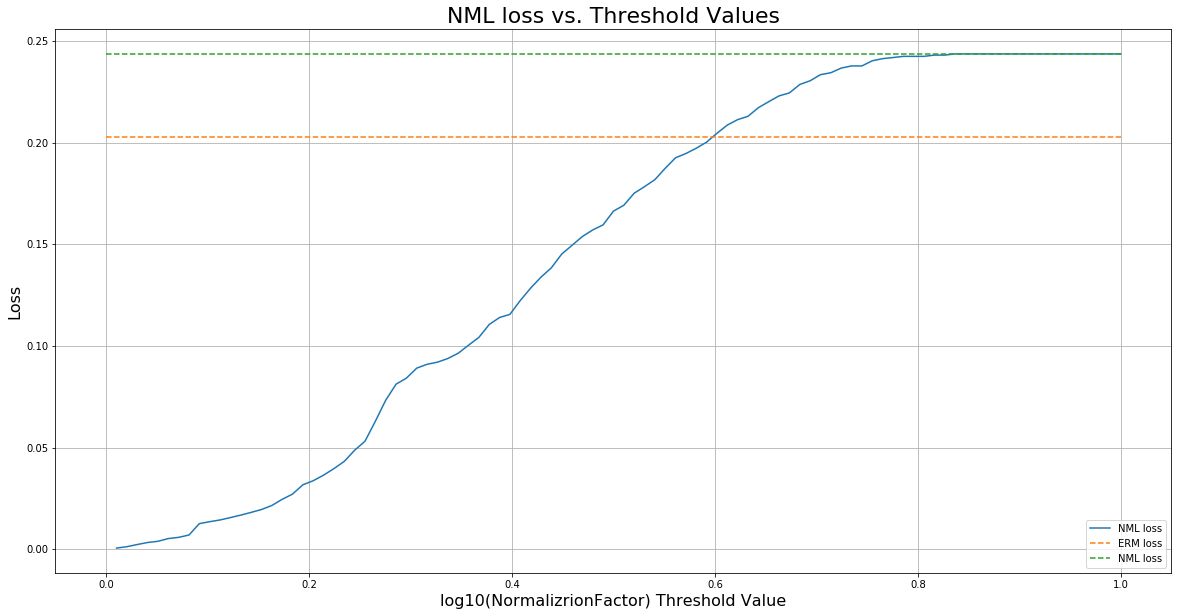

In [8]:
# Plot Loss
plt.figure(figsize=(20,10))
plt.plot(threshold_list, loss_list, label='Thresholded')
plt.plot(threshold_list, list(np.mean(loss_ERM_list)*np.ones([len(threshold_list)])), '--', label='ERM loss')
plt.plot(threshold_list, list(np.mean(loss_NML_list)*np.ones([len(threshold_list)])), '--', label='NML loss')
plt.grid()
plt.legend()
plt.xlabel('log10(NormalizrionFactor) Threshold Value', fontsize=16)
plt.ylabel('Mean Loss', fontsize=16)
plt.title('Loss with threshold between NML and ERM', fontsize=22)
plt.show()

# Plot Acc
plt.figure(figsize=(20,10))
plt.plot(threshold_list, acc_list, label='Thresholded')
plt.plot(threshold_list, list(acc_ERM*np.ones([len(threshold_list)])), '--', label='ERM Acc')
plt.plot(threshold_list, list(acc_NML*np.ones([len(threshold_list)])), '--', label='NML Acc')
plt.grid()
plt.legend()
plt.xlabel('log10(NormalizrionFactor) Threshold Value', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy with threshold between NML and None', fontsize=22)
plt.show()

# Plot Acc CDF
plt.figure(figsize=(20,10))
plt.plot(threshold_list, acc_size_list, label='Threshold Acc CDF')
plt.grid()
plt.xlabel('log10(NormalizrionFactor) Threshold Value', fontsize=16)
plt.ylabel('CDF', fontsize=16)
plt.title('CDF vs. Threshold Values', fontsize=22)
plt.show()


# Plot Acc CDF
plt.figure(figsize=(20,10))
plt.plot(threshold_list, nml_solo_list, label='NML loss')
plt.plot(threshold_list, list(np.mean(loss_ERM_list)*np.ones([len(threshold_list)])), '--', label='ERM loss')
plt.plot(threshold_list, list(np.mean(loss_NML_list)*np.ones([len(threshold_list)])), '--', label='NML loss')
plt.grid()
plt.xlabel('log10(NormalizrionFactor) Threshold Value', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('NML loss vs. Threshold Values', fontsize=22)
plt.legend()
plt.show()

# Correct vs Incorrect

Correct = 913, Incorrect = 87 


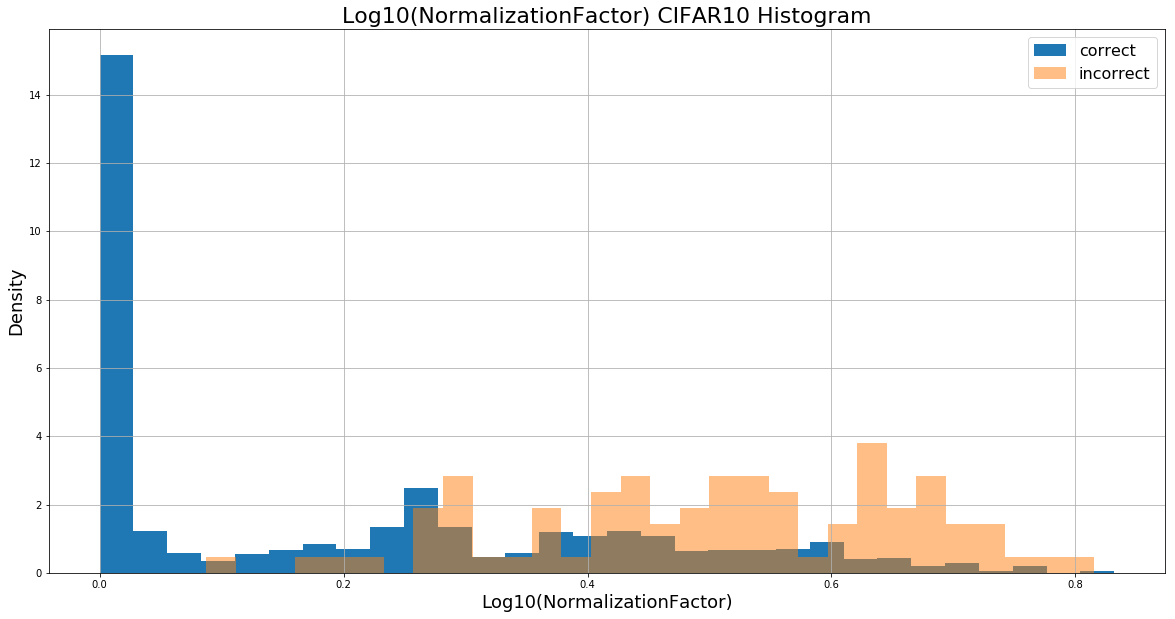

In [9]:
# Plot params
plt.figure(figsize=(20,10))
bins= 30

# Rename
log_normalization_factor_CIFAR10_list = np.log10(np.array(normalization_factor_NML_list))
is_correct_list = is_correct_NML_list

correct =  log_normalization_factor_CIFAR10_list[np.array(is_correct_list)]
incorrect =  log_normalization_factor_CIFAR10_list[~np.array(is_correct_list)]
print('Correct = %d, Incorrect = %d '% (correct.shape[0], incorrect.shape[0]))

# Plot
plt.hist(correct, alpha=1, bins=bins, density=True, label='correct')
plt.hist(incorrect, alpha=0.5, bins=bins, density=True, label='incorrect')
plt.ylabel('Density', fontsize=18)
plt.xlabel('Log10(NormalizationFactor)', fontsize=18)
plt.title('Log10(NormalizationFactor) CIFAR10 Histogram', fontsize=22)
plt.grid()
plt.legend(loc=1, prop={'size': 16})
plt.show()

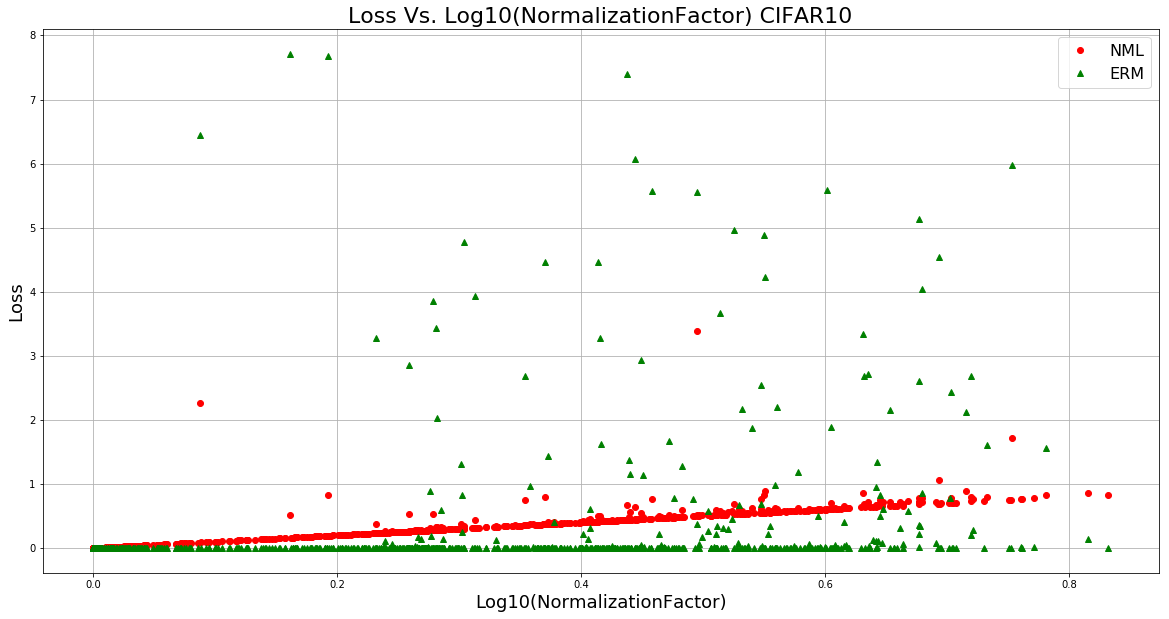

In [10]:
# Plot params
plt.figure(figsize=(20,10))

# Plot
plt.plot(list(log_normalization_factor_CIFAR10_list), loss_NML_list, 'ro', label='NML')
plt.plot(list(log_normalization_factor_CIFAR10_list), loss_ERM_list, 'g^', label='ERM')
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Log10(NormalizationFactor)', fontsize=18)
plt.title('Loss Vs. Log10(NormalizationFactor) CIFAR10', fontsize=22)
plt.grid()
plt.legend(loc=1, prop={'size': 16})
plt.show()

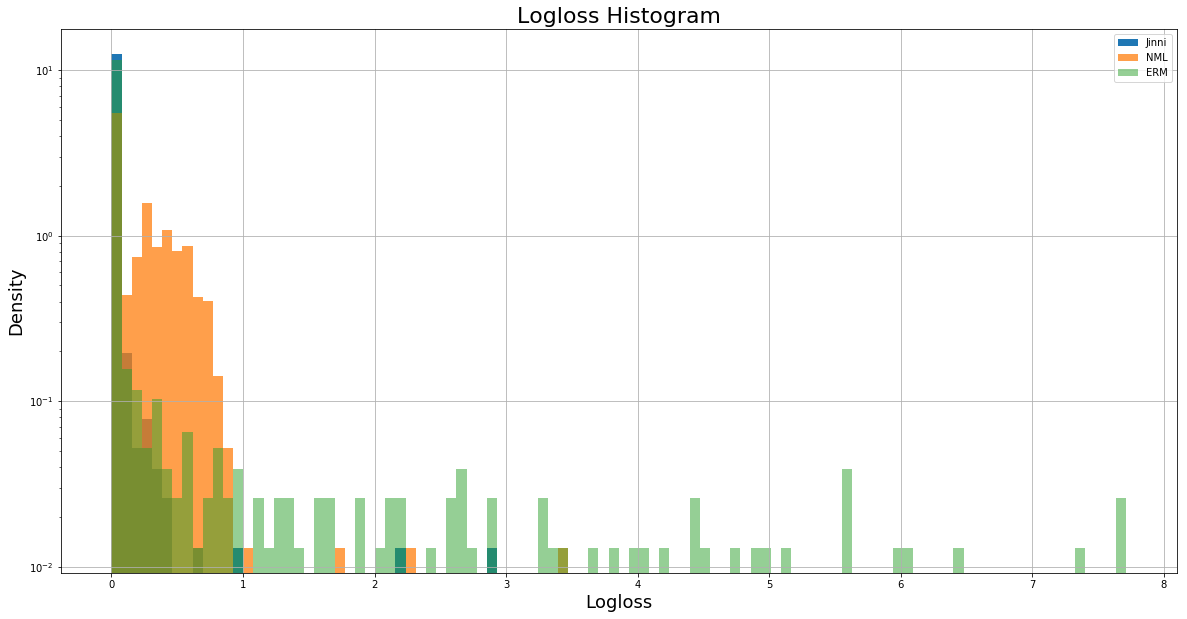

In [11]:
# Plot
bins= 100
plt.figure(figsize=(20,10))
n, bins, patches = plt.hist([loss_NML_list, loss_Jinni_list, loss_ERM_list], bins=bins, alpha=1, label=['NML', 'Jinni', 'ERM'], density=True)
plt.gcf().clear()
plt.hist(loss_Jinni_list, bins=bins, alpha=1, label='Jinni', density=True)
plt.hist(loss_NML_list, bins=bins, alpha=0.75, label='NML', density=True)
plt.hist(loss_ERM_list, bins=bins, alpha=0.5, label='ERM', density=True)
plt.ylabel('Density', fontsize=18)
plt.xlabel('Logloss', fontsize=18)
plt.title('Logloss Histogram', fontsize=22)
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

# Log loss of the series

In [12]:
# Extract from dict
loss_NML_series_list, normalization_factor_NML_series_list, acc_NML_series, is_correct_NML_series_list, _ = \
    get_NML_log_loss_of_the_series_from_dict(results_dict_NML)
loss_ERM_list, acc_ERM, is_correct_ERM_list = get_ERM_log_loss_from_dict(results_dict_NML)
loss_Jinni_list, acc_Jinni = get_jinni_log_loss_from_dict(results_dict_NML)

# Print acc and mean loss
statistics = {'Jinni': pd.Series([acc_Jinni,  np.mean(loss_Jinni_list), np.std(loss_Jinni_list)], 
                                 index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)']),
              'NML Series' : pd.Series([acc_NML_series,  np.mean(loss_NML_series_list), np.std(loss_NML_series_list)],
                                index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)']),
              'ERM' :pd.Series([acc_ERM,  np.mean(loss_ERM_list), np.std(loss_ERM_list)],
                               index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)'])}
print(pd.DataFrame(statistics).to_string())

                      Jinni  NML Series       ERM
Acc                0.993000    0.873000  0.920000
Mean Loss (log10)  0.015735    0.155159  0.202926
Std Loss (log10)   0.125907    0.320489  0.866917


In [13]:
print(np.mean(loss_NML_list), np.mean(loss_NML_series_list))
# for i in range(len(loss_NML_series_list)):
#     print(loss_NML_list[i], loss_NML_series_list[i])

0.24364970049515886 0.15515924660265717


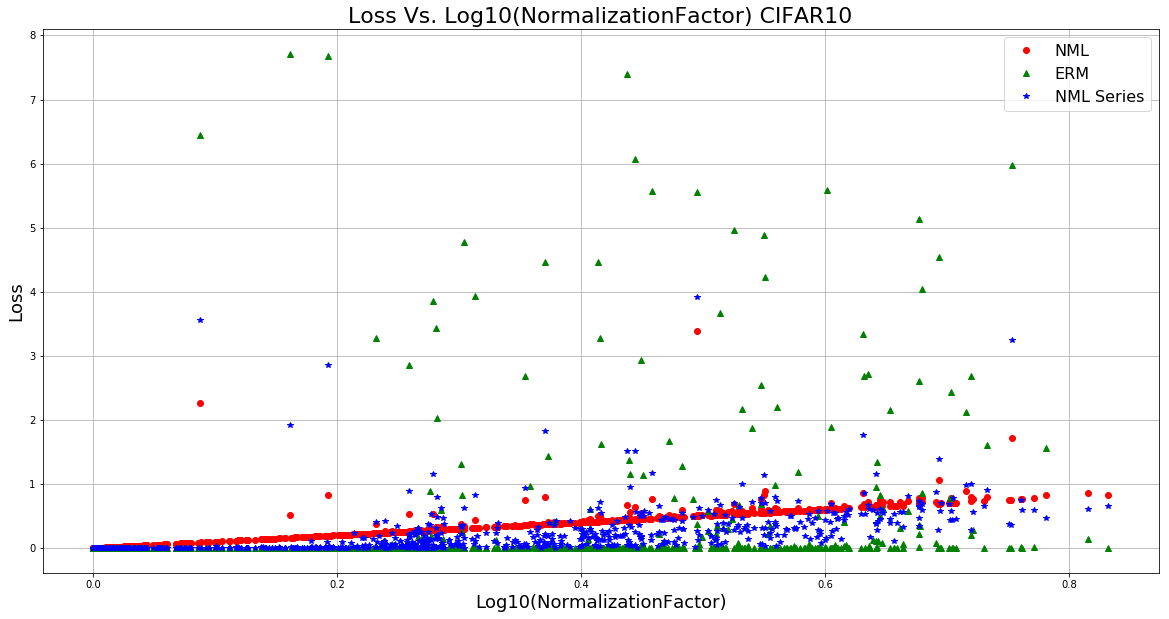

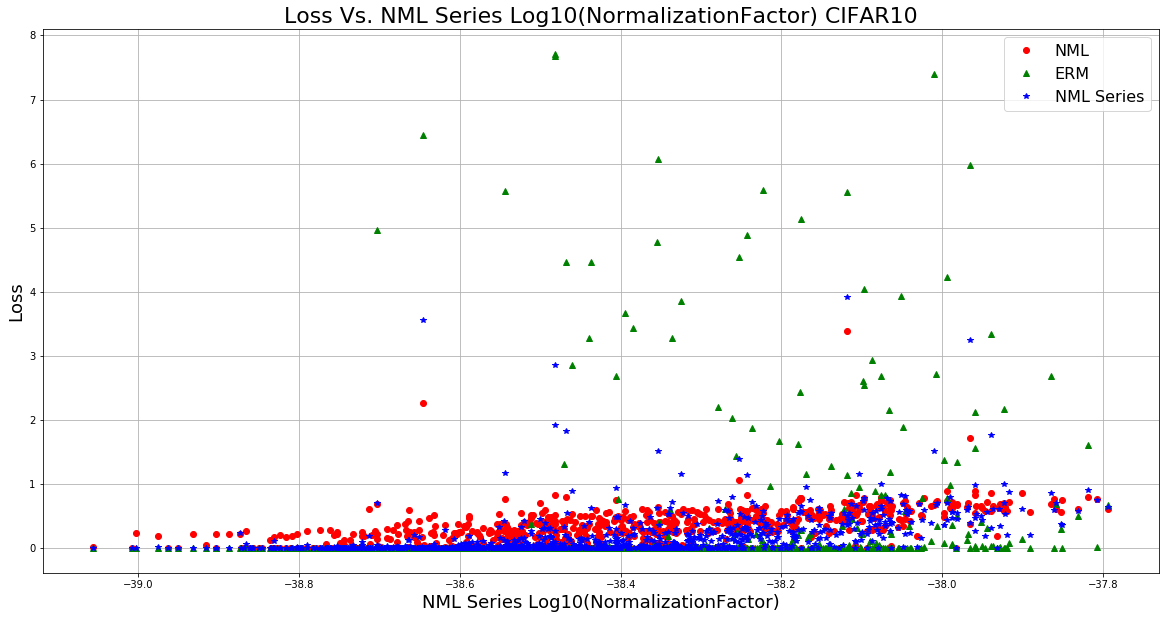

In [14]:
# Plot: Loss vs. NML nomralization factor
plt.figure(figsize=(20,10))
plt.plot(list(log_normalization_factor_CIFAR10_list), loss_NML_list, 'ro', label='NML')
plt.plot(list(log_normalization_factor_CIFAR10_list), loss_ERM_list, 'g^', label='ERM')
plt.plot(list(log_normalization_factor_CIFAR10_list), loss_NML_series_list, 'b*', label='NML Series')
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Log10(NormalizationFactor)', fontsize=18)
plt.title('Loss Vs. Log10(NormalizationFactor) CIFAR10', fontsize=22)
plt.grid()
plt.legend(loc=1, prop={'size': 16})
plt.show()

# Plot: Loss vs. NML series nomralization factor
plt.figure(figsize=(20,10))
log_normalization_factor_NML_series_list = np.log10(normalization_factor_NML_series_list)
plt.plot(list(log_normalization_factor_NML_series_list), loss_NML_list, 'ro', label='NML')
plt.plot(list(log_normalization_factor_NML_series_list), loss_ERM_list, 'g^', label='ERM')
plt.plot(list(log_normalization_factor_NML_series_list), loss_NML_series_list, 'b*', label='NML Series')
plt.ylabel('Loss', fontsize=18)
plt.xlabel('NML Series Log10(NormalizationFactor)', fontsize=18)
plt.title('Loss Vs. NML Series Log10(NormalizationFactor) CIFAR10', fontsize=22)
plt.grid()
plt.legend(loc=1, prop={'size': 16})
plt.show()

# Visualize Specific Sample

In [28]:
# results_dict_NML = results_dict_Random_0 todo: remove
# Load CIFAR10 dataset
trainloader, testloader, classes =  create_cifar10_dataloaders('../data', 1, 1)

idx = 106
prob_jinni, true_label, predicted_jinni_label = extract_jinni_probabilities_list(results_dict_NML[str(idx)])
loss_jinni = compute_log_loss(prob_jinni, true_label)
print(prob_jinni)
print('Loss: %f, [true predicted]=[%f %f], [%s %s]' % 
      (loss_jinni, true_label, predicted_jinni_label, classes[true_label], classes[predicted_jinni_label]))


Files already downloaded and verified
Files already downloaded and verified
[1.8997469908299536e-07, 1.8155644454509456e-07, 0.011623808182775974, 0.9882786273956299, 3.246752866559177e-10, 1.5667712460754046e-08, 8.143262675730512e-05, 5.476699996287415e-11, 1.5774290659464896e-05, 7.094800007906299e-12]
Loss: 0.005121, [true predicted]=[3.000000 3.000000], [cat cat]


Sowing test sample 106
3
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


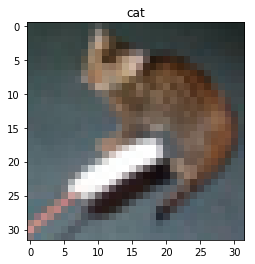

In [30]:
# Show Sample
idx = 106
print('Sowing test sample %d' % idx)
data = testloader.dataset.test_data[idx]
label = testloader.dataset.test_labels[idx]
plt.imshow(data)
plt.title(classes[label])
print(label)
print(classes)

# Random labels

In [17]:
#------
# Random Labels: cifar10 labels are random - Resnet20

# # Random probalility 1.0
# files = ['../output/Random_Labels_results_20180921_195514/results_Random_Labels_20180921_195514.json'] # 0-99
# results_dict_Random_7 = load_dict_from_file_list(files)
# print('Random P=1.0: loaded %d keys' % len(results_dict_Random_7))

# # Random probalility 0.6
# files = ['../output/Random_Labels_results_20180921_195505/results_Random_Labels_20180921_195505.json'] # 0-99
# results_dict_Random_6 = load_dict_from_file_list(files)
# print('Random P=0.6: loaded %d keys' % len(results_dict_Random_6))

# # Random probalility 0.5
# files = ['../output/Random_Labels_results_20180921_195456/results_Random_Labels_20180921_195456.json'] # 0-99
# results_dict_Random_5 = load_dict_from_file_list(files)
# print('Random P=0.5: loaded %d keys' % len(results_dict_Random_5))

# # Random probalility 0.3
# files = ['../output/Random_Labels_results_20180921_195449/results_Random_Labels_20180921_195449.json'] # 0-99
# results_dict_Random_4 = load_dict_from_file_list(files)
# print('Random P=0.3: loaded %d keys' % len(results_dict_Random_4))

# # Random probalility 0.1
# files = ['../output/Random_Labels_results_20180921_195442/results_Random_Labels_20180921_195442.json'] # 0-99
# results_dict_Random_3 = load_dict_from_file_list(files)
# print('Random P=0.1: loaded %d keys' % len(results_dict_Random_3))

# # Random probalility 0.03
# files = ['../output/Random_Labels_results_20180921_195434/results_Random_Labels_20180921_195434.json'] # 0-99
# results_dict_Random_2 = load_dict_from_file_list(files)
# print('Random P=0.03: loaded %d keys' % len(results_dict_Random_2))

# # Random probalility 0.01
# files = ['../output/Random_Labels_results_20180921_195427/results_Random_Labels_20180921_195427.json'] # 0-99
# results_dict_Random_1 = load_dict_from_file_list(files)
# print('Random P=0.01: loaded %d keys' % len(results_dict_Random_1))

# # Random probalility 0.0
# files = ['../output/Random_Labels_results_20180921_195322/results_Random_Labels_20180921_195322.json'] # 0-99
# results_dict_Random_0 = load_dict_from_file_list(files)
# print('Random P=0.0: loaded %d keys' % len(results_dict_Random_0))

# random_prob = [0.0, 0.01, 0.03, 0.1, 0.3, 0.5, 0.6, 1.0]

#------
# Random Labels: cifar10 labels are random - Wide Resnet

# Random probalility 0.0
files = ['../output/Random_Labels_results_20180929_134314/results_Random_Labels_20180929_134314.json'] # 0-99
results_dict_Random_0 = load_dict_from_file_list(files)
print('Random P=0.0: loaded %d keys' % len(results_dict_Random_0))

# Random probalility 0.01
files = ['../output/Random_Labels_results_20180929_134306/results_Random_Labels_20180929_134306.json'] # 0-99
results_dict_Random_1 = load_dict_from_file_list(files)
print('Random P=0.01: loaded %d keys' % len(results_dict_Random_1))

# Random probalility 0.03
files = ['../output/Random_Labels_results_20180929_134258/results_Random_Labels_20180929_134258.json'] # 0-99
results_dict_Random_2 = load_dict_from_file_list(files)
print('Random P=0.03: loaded %d keys' % len(results_dict_Random_2))

# Random probalility 0.1
files = ['../output/Random_Labels_results_20180929_134250/results_Random_Labels_20180929_134250.json'] # 0-99
results_dict_Random_3 = load_dict_from_file_list(files)
print('Random P=0.1: loaded %d keys' % len(results_dict_Random_3))

# Random probalility 0.3
files = ['../output/Random_Labels_results_20180929_134243/results_Random_Labels_20180929_134243.json'] # 0-99
results_dict_Random_4 = load_dict_from_file_list(files)
print('Random P=0.3: loaded %d keys' % len(results_dict_Random_4))

# Random probalility 0.5
files = ['../output/Random_Labels_results_20180929_134236/results_Random_Labels_20180929_134236.json'] # 0-99
results_dict_Random_5 = load_dict_from_file_list(files)
print('Random P=0.5: loaded %d keys' % len(results_dict_Random_5))

# Random probalility 0.6
files = ['../output/Random_Labels_results_20180929_134229/results_Random_Labels_20180929_134229.json'] # 0-99
results_dict_Random_6 = load_dict_from_file_list(files)
print('Random P=0.6: loaded %d keys' % len(results_dict_Random_6))

# Random probalility 1.0
files = ['../output/Random_Labels_results_20180929_134102/results_Random_Labels_20180929_134102.json'] # 0-99
results_dict_Random_7 = load_dict_from_file_list(files)
print('Random P=1.0: loaded %d keys' % len(results_dict_Random_7))

random_prob = [0.0, 0.01, 0.03, 0.1, 0.3, 0.5, 0.6, 1.0]

Random P=0.0: loaded 78 keys
Random P=0.01: loaded 77 keys
Random P=0.03: loaded 78 keys
Random P=0.1: loaded 76 keys
Random P=0.3: loaded 78 keys
Random P=0.5: loaded 76 keys
Random P=0.6: loaded 78 keys
Random P=1.0: loaded 78 keys


In [18]:
from wide_resnet import WideResNet
from resnet import resnet20
model = WideResNet()
wide_resnet_params = sum(p.numel() for p in model.parameters())
model = resnet20()
resnet20_params = sum(p.numel() for p in model.parameters())
print('[WideResnet Resnet20]=[{} {}]'.format(wide_resnet_params, resnet20_params))

[WideResnet Resnet20]=[369498 269722]


In [19]:
# Extract normalization factor
result_dict_list = [results_dict_Random_0, results_dict_Random_1, results_dict_Random_2, results_dict_Random_3,
                    results_dict_Random_4, results_dict_Random_4, results_dict_Random_6, results_dict_Random_7]

# Extract the log normalization factor
mean_log_norm_factor_list = []
std_log_norm_factor_list = []
for results_dict in result_dict_list:
    _, norm_factor_list, _, _, _  = get_NML_log_loss_from_dict(results_dict)
    mean_log_norm_factor_list.append(np.log10(norm_factor_list).mean())
    std_log_norm_factor_list.append(np.log10(norm_factor_list).std())

loss, _, acc  = get_ERM_log_loss_from_dict(results_dict_Random_0)
print('log10(NormalizationFactor): Prob2beRandom={}={}'.format(random_prob, np.round(mean_log_norm_factor_list,3)))

log10(NormalizationFactor): Prob2beRandom=[0.0, 0.01, 0.03, 0.1, 0.3, 0.5, 0.6, 1.0]=[0.931 0.94  0.96  0.982 0.985 0.985 0.991 0.981]


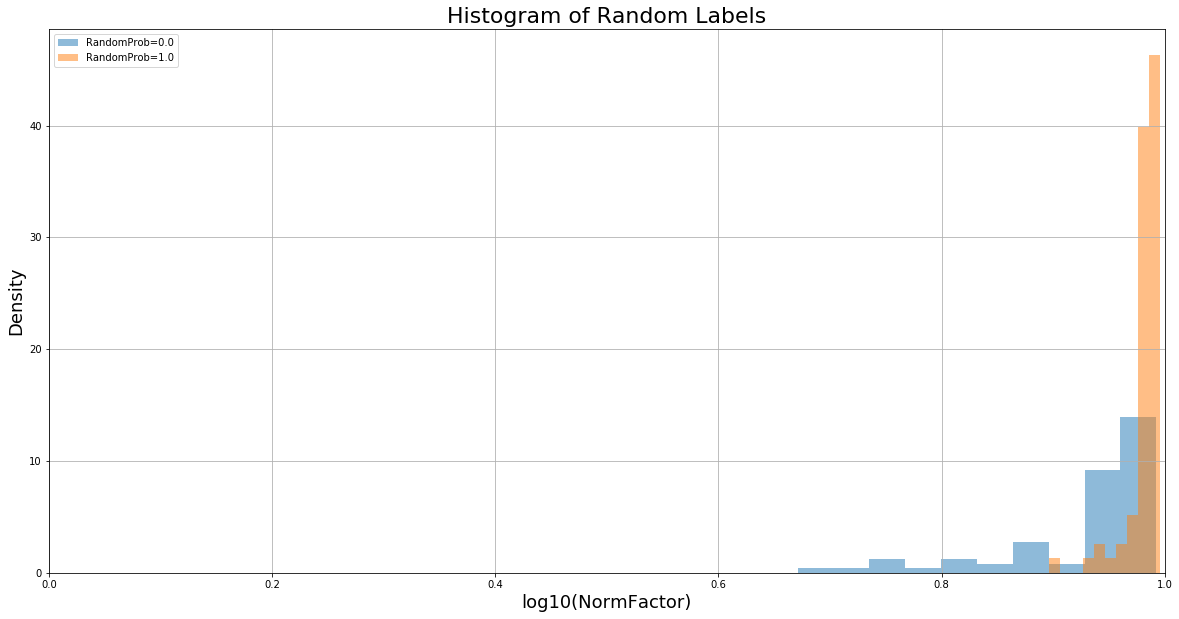

In [20]:
_, norm_factor_list_random_0, _, _, _  = get_NML_log_loss_from_dict(results_dict_Random_0)
_, norm_factor_list_random_7, _, _, _  = get_NML_log_loss_from_dict(results_dict_Random_7)
plt.figure(figsize=(20,10))
plt.hist(np.log10(norm_factor_list_random_0), alpha=0.5, label='RandomProb=0.0', density=True)
plt.hist(np.log10(norm_factor_list_random_7), alpha=0.5, label='RandomProb=1.0', density=True)
plt.legend()
plt.xlabel('log10(NormFactor)', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.title('Histogram of Random Labels', fontsize=22)
plt.xlim([0, 1])
plt.grid()

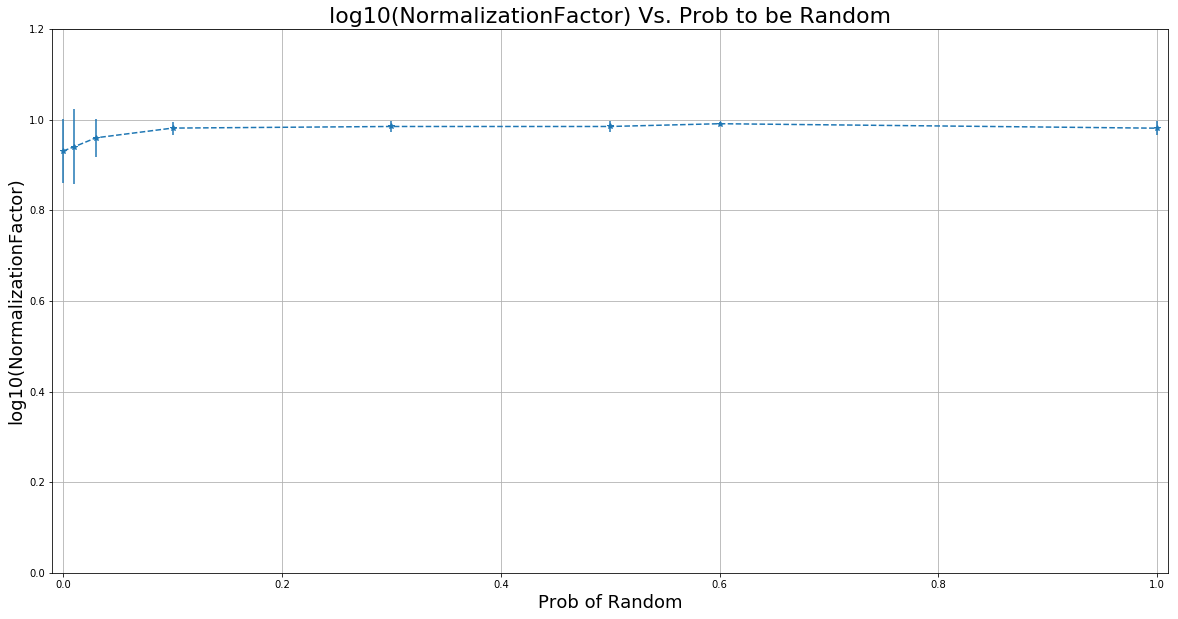

In [21]:
# Plot 
plt.figure(figsize=(20,10))
plt.errorbar(random_prob,  mean_log_norm_factor_list, yerr=std_log_norm_factor_list, fmt='--*',  label='NML')
plt.ylabel('log10(NormalizationFactor)', fontsize=18)
plt.xlabel('Prob of Random', fontsize=18)
plt.title('log10(NormalizationFactor) Vs. Prob to be Random', fontsize=22)
plt.ylim([0,1.2])
plt.xlim([-0.01,1.01])
plt.grid()
plt.show()

log10(NormalizationFactor) series: Prob2beRandom=[0.0, 0.01, 0.03, 0.1, 0.3, 0.5, 0.6, 1.0]=[ -0.357  -0.229  -0.378  -0.315  -1.11   -1.11   -1.83  -90.786]
Loss: [ 0.266  0.355  0.591  0.778  1.598  1.598  2.161 10.694]
Acc: [0.83  0.821 0.753 0.672 0.345 0.345 0.18  0.111]


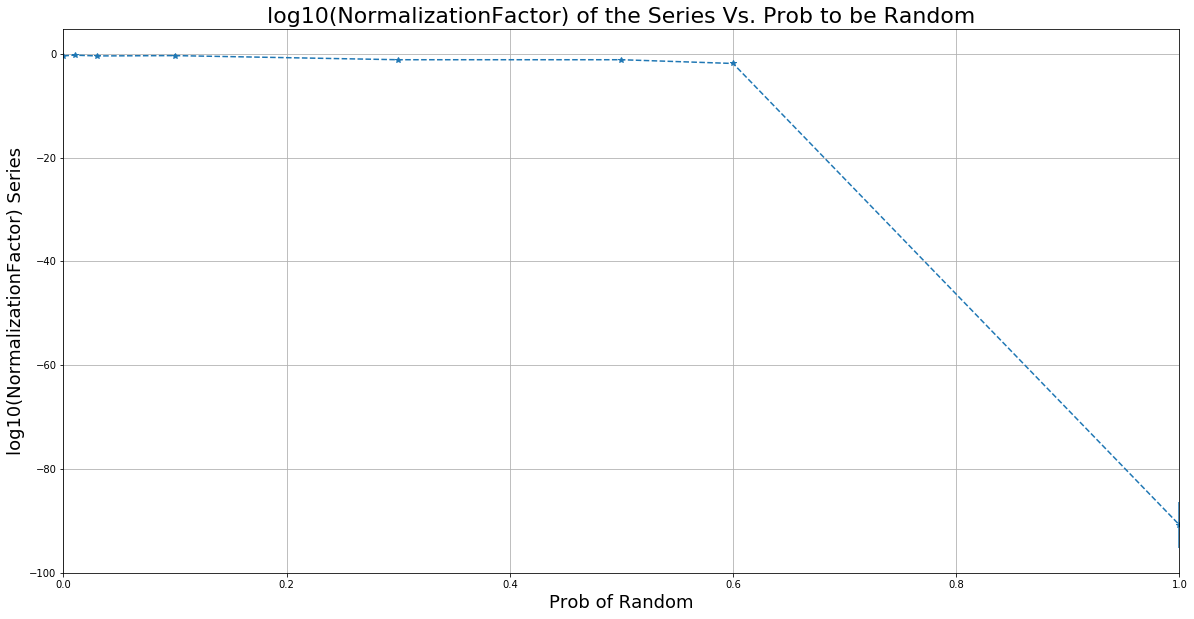

In [33]:
# Extract normalization factor of the series
result_dict_list = [results_dict_Random_0, results_dict_Random_1, results_dict_Random_2, results_dict_Random_3,
                    results_dict_Random_4, results_dict_Random_4, results_dict_Random_6, results_dict_Random_7]

# Extract the log normalization factor
mean_log_norm_factor_list = []
std_log_norm_factor_list = []
acc_series_list = []
loss_series_list = []
for results_dict in result_dict_list:
    loss_series, norm_factor_list, acc_series, _, _  = get_NML_log_loss_of_the_series_from_dict(results_dict)
    mean_log_norm_factor_list.append(np.log10(norm_factor_list).mean())
    std_log_norm_factor_list.append(np.log10(norm_factor_list).std())
    loss_series_list.append(np.mean(loss_series))
    acc_series_list.append(acc_series)
print('log10(NormalizationFactor) series: Prob2beRandom={}={}'.format(random_prob, np.round(mean_log_norm_factor_list,3)))
print('Loss: {}'.format(np.round(loss_series_list,3)))
print('Acc: {}'.format(np.round(acc_series_list,3)))
# Figure 
plt.figure(figsize=(20,10))
plt.errorbar(random_prob,  mean_log_norm_factor_list, yerr=std_log_norm_factor_list, fmt='--*',  label='NML')
plt.ylabel('log10(NormalizationFactor) Series', fontsize=18)
plt.xlabel('Prob of Random', fontsize=18)
plt.title('log10(NormalizationFactor) of the Series Vs. Prob to be Random', fontsize=22)
# plt.ylim([0,1])
plt.xlim([0,1])
plt.grid()
plt.show()


# Random  labels- few epochs

In [41]:
# Random probalility 0.0
files = ['../output/Random_Labels_results_20181005_123614/results_Random_Labels_20181005_123614.json']
results_dict_Random_0 = load_dict_from_file_list(files)
print('Random P=0.0: loaded %d keys' % len(results_dict_Random_0))

# Random probalility 1.0
files = ['../output/Random_Labels_results_20181005_124136/results_Random_Labels_20181005_124136.json'] 
results_dict_Random_1 = load_dict_from_file_list(files)
print('Random P=1.0: loaded %d keys' % len(results_dict_Random_1))

random_prob = [0.0, 1.0]

# Extract normalization factor
result_dict_list = [results_dict_Random_0, results_dict_Random_1]

# Extract the log normalization factor
mean_log_norm_factor_list = []
std_log_norm_factor_list = []
for results_dict in result_dict_list:
    _, norm_factor_list, _, _, _  = get_NML_log_loss_from_dict(results_dict)
    mean_log_norm_factor_list.append(np.log10(norm_factor_list).mean())
    std_log_norm_factor_list.append(np.log10(norm_factor_list).std())

loss, _, acc  = get_ERM_log_loss_from_dict(results_dict_Random_0)
print('log10(NormalizationFactor): Prob2beRandom={}={}'.format(random_prob, np.round(mean_log_norm_factor_list,3)))

Random P=0.0: loaded 100 keys
Random P=1.0: loaded 100 keys
log10(NormalizationFactor): Prob2beRandom=[0.0, 1.0]=[0.507 0.737]


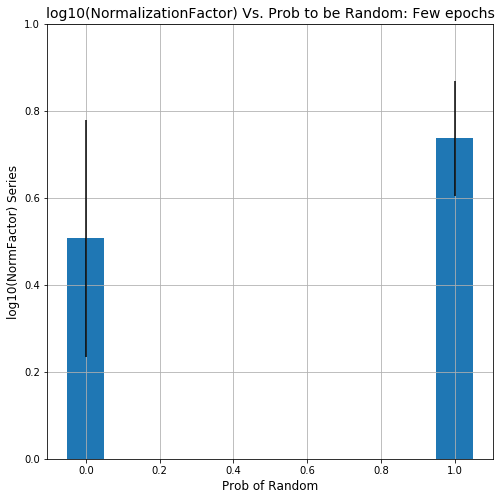

In [42]:
# Plot normalization factor
plt.figure(figsize=(8,8))
plt.bar(random_prob,  mean_log_norm_factor_list, 0.1, yerr=std_log_norm_factor_list,  label='NML')
plt.ylabel('log10(NormFactor) Series', fontsize=12)
plt.xlabel('Prob of Random', fontsize=12)
plt.title('log10(NormalizationFactor) Vs. Prob to be Random: Few epochs', fontsize=14)
plt.ylim([0,1])
# plt.xlim([0,1])
plt.grid()
plt.show()

In [43]:
# Plot preformance of NML and ERM
nml_loss, _, nml_acc, _, _  = get_NML_log_loss_from_dict(results_dict_Random_0)
erm_loss, erm_acc, _ = get_ERM_log_loss_from_dict(results_dict_Random_0)
nml_series_loss, _, nml_series_acc, _, _=get_NML_log_loss_of_the_series_from_dict(results_dict_Random_0)
# Print acc and mean loss
statistics = {'NML' : pd.Series([nml_acc,  np.mean(nml_loss), np.std(nml_loss)],
                                index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)']),
              'ERM' :pd.Series([erm_acc,  np.mean(erm_loss), np.std(erm_loss)],
                               index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)']),
             'NML Series' :pd.Series([nml_series_acc,  np.mean(nml_series_loss), np.std(nml_series_loss)],
                               index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)'])}
print(pd.DataFrame(statistics).to_string())

                        NML       ERM  NML Series
Acc                0.860000  0.860000    0.830000
Mean Loss (log10)  0.507622  0.555162    0.283443
Std Loss (log10)   0.273617  1.767140    0.328704


Random P=0.0: loaded 200 keys
Random P=0.01: loaded 190 keys
Random P=0.03: loaded 194 keys
Random P=0.1: loaded 189 keys
Random P=0.3: loaded 197 keys
Random P=0.5: loaded 191 keys
Random P=0.6: loaded 194 keys
Random P=1.0: loaded 190 keys
Prob2beRandom=[0.0, 0.01, 0.03, 0.1, 0.3, 0.5, 0.6, 1.0]
log10(NormalizationFactor)=[0.527 0.566 0.619 0.751 0.825 0.825 0.866 0.707]
                        NML       ERM
Acc                0.795000  0.900000
Mean Loss (log10)  0.528563  0.362585
Std Loss (log10)   0.260636  1.375623


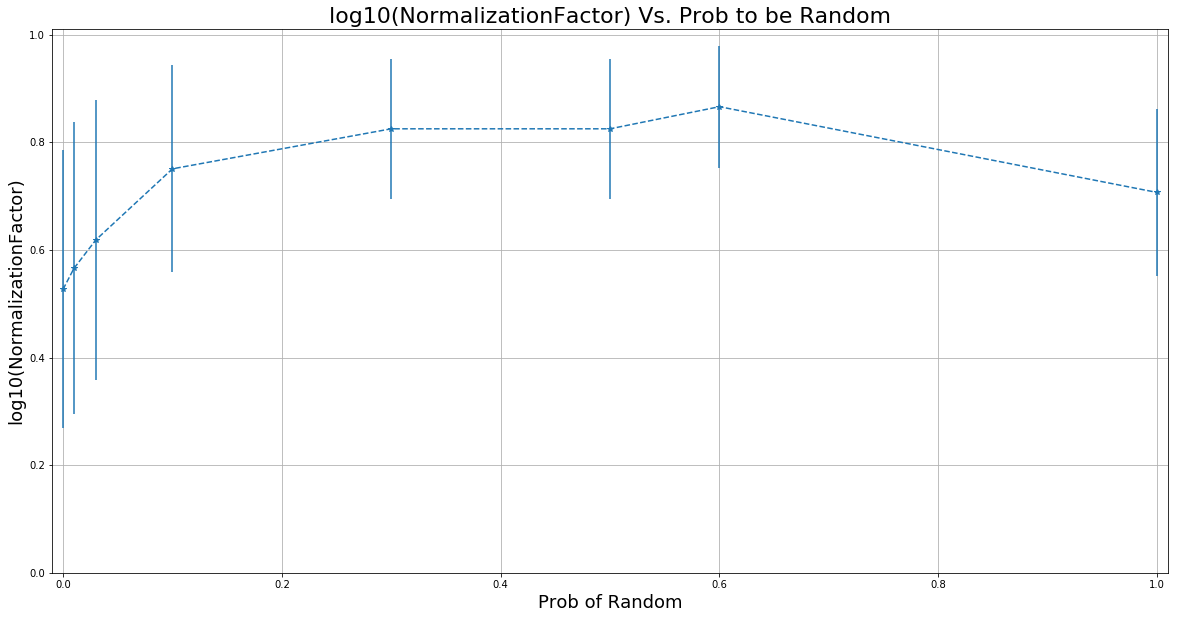

In [2]:
# scp -r aws8:/home/ubuntu/random/random_0/output/Random_Labels_results_20181012_101001 . 
# scp -r aws8:/home/ubuntu/random/random_1/output/Random_Labels_results_20181012_101106 .
# scp -r aws8:/home/ubuntu/random/random_2/output/Random_Labels_results_20181012_101147 .
# scp -r aws8:/home/ubuntu/random/random_3/output/Random_Labels_results_20181012_101159 .
# scp -r aws8:/home/ubuntu/random/random_4/output/Random_Labels_results_20181012_101222 .
# scp -r aws8:/home/ubuntu/random/random_5/output/Random_Labels_results_20181012_101238 .
# scp -r aws8:/home/ubuntu/random/random_6/output/Random_Labels_results_20181012_101353 .
# scp -r aws8:/home/ubuntu/random/random_7/output/Random_Labels_results_20181012_101406 .

#------
# Random Labels: cifar10 labels are random - Wide Resnet

# Random probalility 0.0
files = ['../output/Random_Labels_results_20181012_101001/results_Random_Labels_20181012_101001.json'] # 0-99
results_dict_Random_0 = load_dict_from_file_list(files)
print('Random P=0.0: loaded %d keys' % len(results_dict_Random_0))

# Random probalility 0.01
files = ['../output/Random_Labels_results_20181012_101106/results_Random_Labels_20181012_101106.json'] # 0-99
results_dict_Random_1 = load_dict_from_file_list(files)
print('Random P=0.01: loaded %d keys' % len(results_dict_Random_1))

# Random probalility 0.03
files = ['../output/Random_Labels_results_20181012_101147/results_Random_Labels_20181012_101147.json'] # 0-99
results_dict_Random_2 = load_dict_from_file_list(files)
print('Random P=0.03: loaded %d keys' % len(results_dict_Random_2))

# Random probalility 0.1
files = ['../output/Random_Labels_results_20181012_101159/results_Random_Labels_20181012_101159.json'] # 0-99
results_dict_Random_3 = load_dict_from_file_list(files)
print('Random P=0.1: loaded %d keys' % len(results_dict_Random_3))

# Random probalility 0.3
files = ['../output/Random_Labels_results_20181012_101222/results_Random_Labels_20181012_101222.json'] # 0-99
results_dict_Random_4 = load_dict_from_file_list(files)
print('Random P=0.3: loaded %d keys' % len(results_dict_Random_4))

# Random probalility 0.5
files = ['../output/Random_Labels_results_20181012_101238/results_Random_Labels_20181012_101238.json'] # 0-99
results_dict_Random_5 = load_dict_from_file_list(files)
print('Random P=0.5: loaded %d keys' % len(results_dict_Random_5))

# Random probalility 0.6
files = ['../output/Random_Labels_results_20181012_101353/results_Random_Labels_20181012_101353.json'] # 0-99
results_dict_Random_6 = load_dict_from_file_list(files)
print('Random P=0.6: loaded %d keys' % len(results_dict_Random_6))

# Random probalility 1.0
files = ['../output/Random_Labels_results_20181012_101406/results_Random_Labels_20181012_101406.json'] # 0-99
results_dict_Random_7 = load_dict_from_file_list(files)
print('Random P=1.0: loaded %d keys' % len(results_dict_Random_7))

random_prob = [0.0, 0.01, 0.03, 0.1, 0.3, 0.5, 0.6, 1.0]

# Extract normalization factor
result_dict_list = [results_dict_Random_0, results_dict_Random_1, results_dict_Random_2, results_dict_Random_3,
                    results_dict_Random_4, results_dict_Random_4, results_dict_Random_6, results_dict_Random_7]


# Extract the log normalization factor
mean_log_norm_factor_list = []
std_log_norm_factor_list = []
for results_dict in result_dict_list:
    _, norm_factor_list, _, _, _  = get_NML_log_loss_from_dict(results_dict)
    mean_log_norm_factor_list.append(np.log10(norm_factor_list).mean())
    std_log_norm_factor_list.append(np.log10(norm_factor_list).std())

print('Prob2beRandom={}'.format(random_prob))
print('log10(NormalizationFactor)={}'.format( np.round(mean_log_norm_factor_list,3)))


# Plot preformance of NML and ERM
nml_loss, _, nml_acc, _, _  = get_NML_log_loss_from_dict(results_dict_Random_0)
erm_loss, erm_acc, _ = get_ERM_log_loss_from_dict(results_dict_Random_0)
# Print acc and mean loss
statistics = {'NML' : pd.Series([nml_acc,  np.mean(nml_loss), np.std(nml_loss)],
                                index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)']),
              'ERM' :pd.Series([erm_acc,  np.mean(erm_loss), np.std(erm_loss)],
                               index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)'])}
print(pd.DataFrame(statistics).to_string())


# Plot 
plt.figure(figsize=(20,10))
plt.errorbar(random_prob,  mean_log_norm_factor_list, yerr=std_log_norm_factor_list, fmt='--*',  label='NML')
plt.ylabel('log10(NormalizationFactor)', fontsize=18)
plt.xlabel('Prob of Random', fontsize=18)
plt.title('log10(NormalizationFactor) Vs. Prob to be Random', fontsize=22)
plt.ylim([0,1.01])
plt.xlim([-0.01,1.01])
plt.grid()
plt.show()

In [5]:
nml_loss_list = []
nml_acc_list = []
erm_loss_list = []
erm_acc_list = []
for dict_num, results_dict in enumerate(result_dict_list):
    print('Dict Number:' , dict_num)
    nml_loss, _, nml_acc, is_correct_nml, idx_in_dataset  = get_NML_log_loss_from_dict(results_dict, is_random_labels = True)
    erm_loss, erm_acc, is_correct_erm = get_ERM_log_loss_from_dict(results_dict, is_random_labels = True)
    nml_loss_list.append(np.mean(nml_loss))
    nml_acc_list.append(nml_acc)
    erm_loss_list.append(np.mean(erm_loss))
    erm_acc_list.append(erm_acc)
    print(erm_acc)



Dict Number: 0
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
0.9
Dict Number: 1
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
0.8368421052631579
Dict Number: 2
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
0.8298969072164949
Dict Number: 3
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
0.8042328042328042
Dict Number: 4
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
0.5888324873096447
Dict Number: 5
Files already downloaded and verified
Files already downloaded and ver

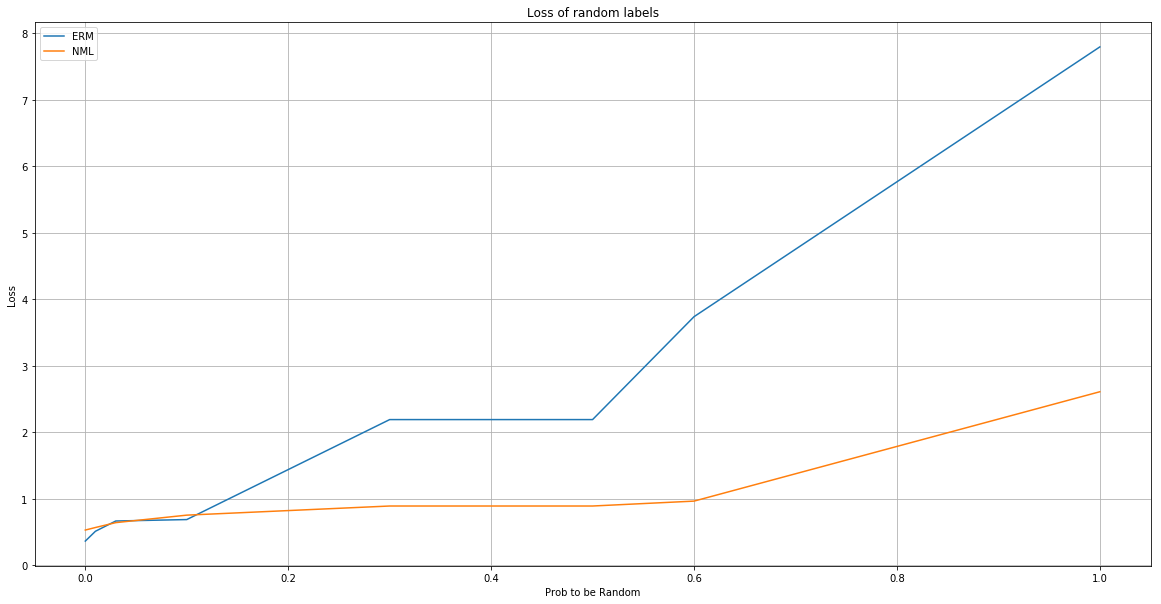

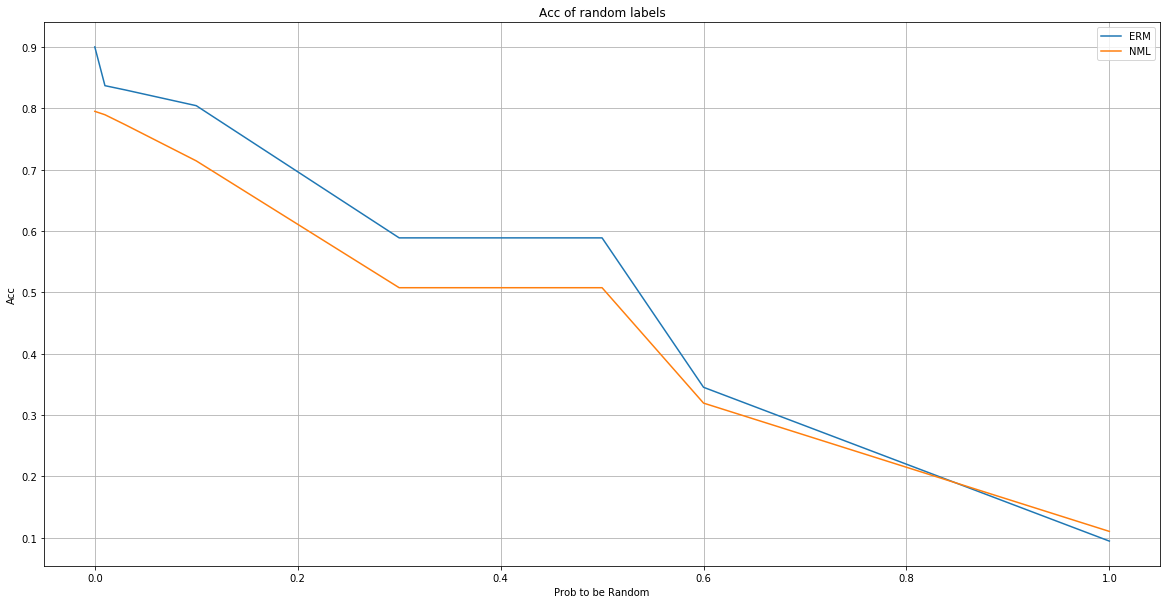

In [4]:
plt.figure(figsize=(20,10))
plt.plot(random_prob, erm_loss_list, label='ERM')
plt.plot(random_prob, nml_loss_list, label='NML')
plt.grid()
plt.title('Loss of random labels')
plt.ylabel('Loss')
plt.xlabel('Prob to be Random')
plt.legend()
plt.show()

plt.figure(figsize=(20,10))
plt.plot(random_prob, erm_acc_list, label='ERM')
plt.plot(random_prob, nml_acc_list, label='NML')
plt.grid()
plt.title('Acc of random labels')
plt.ylabel('Acc')
plt.xlabel('Prob to be Random')
plt.legend()
plt.show()

In [39]:
nml_loss, _, nml_acc, is_correct_nml, idx_in_dataset  = get_NML_log_loss_from_dict(results_dict_Random_0)
erm_loss, erm_acc, is_correct_erm = get_ERM_log_loss_from_dict(results_dict_Random_0)
nml_series_loss, _, nml_series_acc, is_correct_nml_series, _  = get_NML_log_loss_of_the_series_from_dict(results_dict_Random_0)

erm_better = 0
erm_correct = 0
idx_erm_better = []
idx_erm_better_series = []
for (is_correct_nml_single, is_correct_erm_single, is_correct_nml_series_single, idx_single) in zip(is_correct_nml, is_correct_erm, is_correct_nml_series, idx_in_dataset):
#     print(is_correct_nml_single, is_correct_erm_single, idx_single)
    if is_correct_erm_single == True:
        erm_correct +=1
#     if is_correct_nml_single
    print(is_correct_erm_single, is_correct_nml_single)
    if is_correct_erm_single == True and is_correct_nml_single == False:
        erm_better +=1
        print('Now!')
        idx_erm_better.append(idx_single)
    if is_correct_erm_single == True and is_correct_nml_series_single == False:
        erm_better +=1
        print('Now!')
        idx_erm_better_series.append(idx_single)
print('acc=%f' % (erm_correct/len(is_correct_erm)))
print(erm_better)

True True
True True
False True
True False
Now!
True True
True True
True True
True True
True True
True False
Now!
Now!
True True
True True
True True
True True
True True
True True
False False
True True
True True
True True
True True
True True
False False
True False
Now!
Now!
True True
True True
True True
True True
True True
True True
False False
True True
True True
False False
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True
Now!
True True
True True
False False
True True
False True
True True
False False
False False
True True
Now!
True True
Now!
True True
True True
True True
True True
True False
Now!
Now!
True True
True True
True True
False False
True True
True True
True True
True True
True True
True True
False False
True True
True True
True True
True True
True True
True True
True True
True False
Now!
True True
True True
True True
True True
True True
True True
True True
True True
True True
True True


In [40]:
print(idx_erm_better)
print(idx_erm_better_series)

['100', '106', '119', '154', '171', '184', '187', '189', '192', '193', '195', '2', '25', '37', '42', '47', '57', '61', '66', '7', '71', '76', '78', '8', '95', '96']
['106', '119', '140', '149', '15', '154', '181', '184', '189', '2', '4', '59', '61', '7', '76', '87', '94']


In [27]:
# idx 100
prob = [1.38*10**-9, 1.15*10**-11, 0.0002, 6.34*10**-8, 0.9933, 0.00191, 0.445*10**-9, 0.9995, 0.0001, 2.05*10**-10]
norm = np.sum(prob)
print(np.log10(norm))

0.29994509117799206


In [14]:
# idx 2
prob_1 = [0.7553929090499878, 0.9950398206710815, 0.0004554125480353832, 0.000011090248335676733, 8.38192359964296e-9, 7.86031684185673e-9, 1.336318788958124e-8, 0.07288163155317307, 0.9995853304862976, 1.1424120316405606e-7]
norm_1 = np.sum(prob_1)
print(np.log10(norm_1))
normalize_prob_1 = np.array(prob_1)/norm_1
print(np.argmax(normalize_prob_1))

prob_2 = [0.8490927219390869, 0.9983795881271362, 0.0001615415239939466, 0.0000030792034522164613, 2.0058756877716633e-9, 0.0000013263224900583737, 1.2928782489041168e-9, 0.504626989364624, 0.9833781719207764, 0.4571777284145355]
norm_2 = np.sum(prob_2)
print(np.log10(norm_2))
normalize_prob_2 = np.array(prob_2)/norm_2
print(np.argmax(normalize_prob_2))

print(np.argmax(0.5*((norm_1)*normalize_prob_1+(norm_2)*normalize_prob_2)))

0.45076723253055506
8
0.5789623640975908
1
1


# Random labels- fix loss
There was a bug!! stop training when loss was 0.001

Random P=0.0: loaded 131 keys
Random P=1.0: loaded 72 keys
log10(NormalizationFactor): Prob2beRandom=[0.0, 1.0]=[0.321 0.94 ]


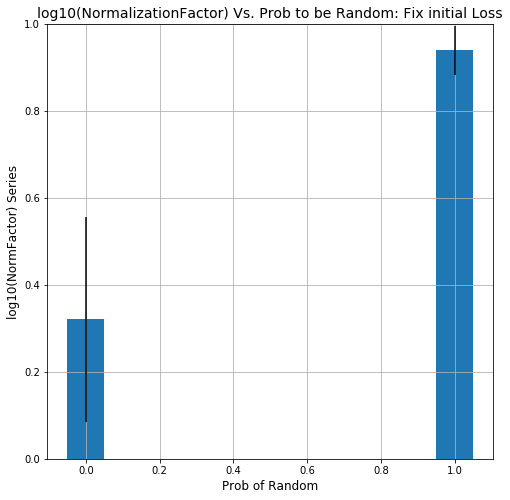

                        NML       ERM
Acc                0.847328  0.877863
Mean Loss (log10)  0.336112  0.425504
Std Loss (log10)   0.261544  1.436014


In [29]:

# Random probalility 0.0
files = ['../output/Random_Labels_results_20181005_124942/results_Random_Labels_20181005_124942.json']
results_dict_Random_0 = load_dict_from_file_list(files)
print('Random P=0.0: loaded %d keys' % len(results_dict_Random_0))

# Random probalility 1.0
files = ['../output/Random_Labels_results_20181005_125147/results_Random_Labels_20181005_125147.json'] 
results_dict_Random_1 = load_dict_from_file_list(files)
print('Random P=1.0: loaded %d keys' % len(results_dict_Random_1))

random_prob = [0.0, 1.0]

# Extract normalization factor
result_dict_list = [results_dict_Random_0, results_dict_Random_1]

# Extract the log normalization factor
mean_log_norm_factor_list = []
std_log_norm_factor_list = []
for results_dict in result_dict_list:
    _, norm_factor_list, _, _, _  = get_NML_log_loss_from_dict(results_dict)
    mean_log_norm_factor_list.append(np.log10(norm_factor_list).mean())
    std_log_norm_factor_list.append(np.log10(norm_factor_list).std())

loss, _, acc  = get_ERM_log_loss_from_dict(results_dict_Random_0)
print('log10(NormalizationFactor): Prob2beRandom={}={}'.format(random_prob, np.round(mean_log_norm_factor_list,3)))

# Plot normalization factor
plt.figure(figsize=(8,8))
plt.bar(random_prob,  mean_log_norm_factor_list, 0.1, yerr=std_log_norm_factor_list,  label='NML')
plt.ylabel('log10(NormFactor) Series', fontsize=12)
plt.xlabel('Prob of Random', fontsize=12)
plt.title('log10(NormalizationFactor) Vs. Prob to be Random: Fix initial Loss', fontsize=14)
plt.ylim([0,1])
# plt.xlim([0,1])
plt.grid()
plt.show()

# Plot preformance of NML and ERM
nml_loss, _, nml_acc, _, _  = get_NML_log_loss_from_dict(results_dict_Random_0)
erm_loss, erm_acc, _ = get_ERM_log_loss_from_dict(results_dict_Random_0)
# Print acc and mean loss
statistics = {'NML' : pd.Series([nml_acc,  np.mean(nml_loss), np.std(nml_loss)],
                                index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)']),
              'ERM' :pd.Series([erm_acc,  np.mean(erm_loss), np.std(erm_loss)],
                               index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)'])}
print(pd.DataFrame(statistics).to_string())

In [30]:
#------
# Random Labels: cifar10 labels are random - Wide Resnet

# Random probalility 0.0
files = ['../output/Random_Labels_results_20181009_145417/results_Random_Labels_20181009_145417.json'] # 0-99
results_dict_Random_0 = load_dict_from_file_list(files)
print('Random P=0.0: loaded %d keys' % len(results_dict_Random_0))

# Random probalility 0.01
files = ['../output/Random_Labels_results_20181009_145506/results_Random_Labels_20181009_145506.json'] # 0-99
results_dict_Random_1 = load_dict_from_file_list(files)
print('Random P=0.01: loaded %d keys' % len(results_dict_Random_1))

# Random probalility 0.03
files = ['../output/Random_Labels_results_20181009_145528/results_Random_Labels_20181009_145528.json'] # 0-99
results_dict_Random_2 = load_dict_from_file_list(files)
print('Random P=0.03: loaded %d keys' % len(results_dict_Random_2))

# Random probalility 0.1
files = ['../output/Random_Labels_results_20181009_145553/results_Random_Labels_20181009_145553.json'] # 0-99
results_dict_Random_3 = load_dict_from_file_list(files)
print('Random P=0.1: loaded %d keys' % len(results_dict_Random_3))

# Random probalility 0.3
files = ['../output/Random_Labels_results_20181009_145613/results_Random_Labels_20181009_145613.json'] # 0-99
results_dict_Random_4 = load_dict_from_file_list(files)
print('Random P=0.3: loaded %d keys' % len(results_dict_Random_4))

# Random probalility 0.5
files = ['../output/Random_Labels_results_20181009_145626/results_Random_Labels_20181009_145626.json'] # 0-99
results_dict_Random_5 = load_dict_from_file_list(files)
print('Random P=0.5: loaded %d keys' % len(results_dict_Random_5))

# Random probalility 0.6
files = ['../output/Random_Labels_results_20181009_145645/results_Random_Labels_20181009_145645.json'] # 0-99
results_dict_Random_6 = load_dict_from_file_list(files)
print('Random P=0.6: loaded %d keys' % len(results_dict_Random_6))

# Random probalility 1.0
files = ['../output/Random_Labels_results_20181009_145706/results_Random_Labels_20181009_145706.json'] # 0-99
results_dict_Random_7 = load_dict_from_file_list(files)
print('Random P=1.0: loaded %d keys' % len(results_dict_Random_7))

random_prob = [0.0, 0.01, 0.03, 0.1, 0.3, 0.5, 0.6, 1.0]

Random P=0.0: loaded 20 keys
Random P=0.01: loaded 20 keys
Random P=0.03: loaded 20 keys
Random P=0.1: loaded 20 keys
Random P=0.3: loaded 20 keys
Random P=0.5: loaded 19 keys
Random P=0.6: loaded 19 keys
Random P=1.0: loaded 17 keys


log10(NormalizationFactor): Prob2beRandom=[0.0, 0.01, 0.03, 0.1, 0.3, 0.5, 0.6, 1.0]=[0.898 0.93  0.939 0.976 0.982 0.982 0.987 0.983]


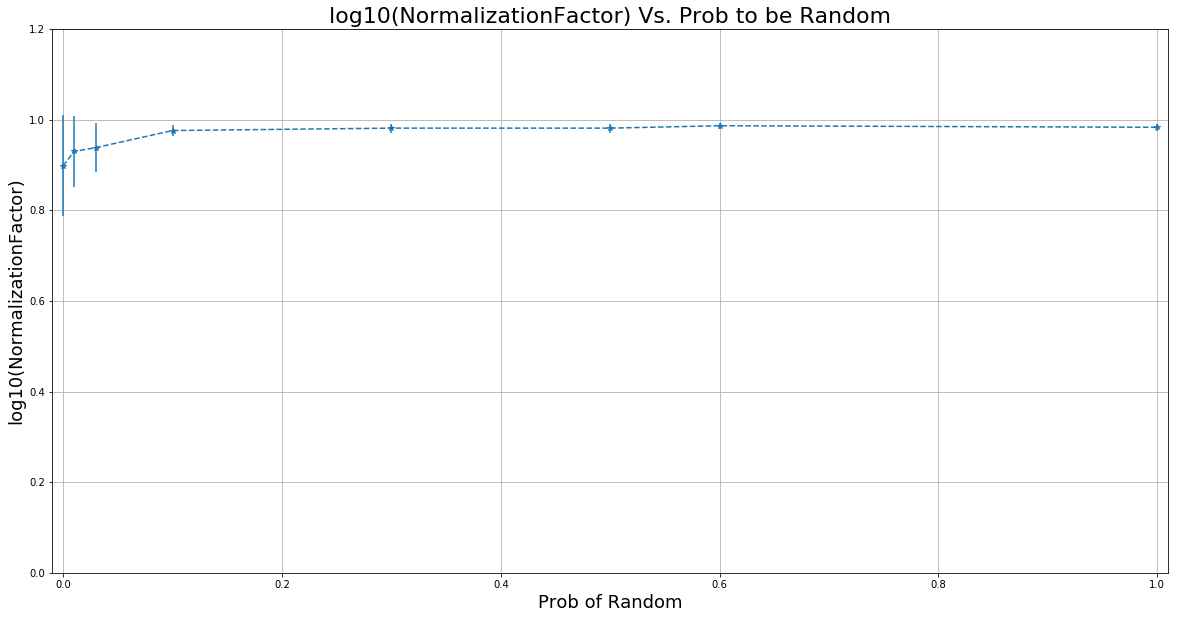

In [31]:
# Extract normalization factor
result_dict_list = [results_dict_Random_0, results_dict_Random_1, results_dict_Random_2, results_dict_Random_3,
                    results_dict_Random_4, results_dict_Random_4, results_dict_Random_6, results_dict_Random_7]

# Extract the log normalization factor
mean_log_norm_factor_list = []
std_log_norm_factor_list = []
for results_dict in result_dict_list:
    _, norm_factor_list, _, _, _  = get_NML_log_loss_from_dict(results_dict)
    mean_log_norm_factor_list.append(np.log10(norm_factor_list).mean())
    std_log_norm_factor_list.append(np.log10(norm_factor_list).std())

loss, _, acc  = get_ERM_log_loss_from_dict(results_dict_Random_0)
print('log10(NormalizationFactor): Prob2beRandom={}={}'.format(random_prob, np.round(mean_log_norm_factor_list,3)))
# Plot 
plt.figure(figsize=(20,10))
plt.errorbar(random_prob,  mean_log_norm_factor_list, yerr=std_log_norm_factor_list, fmt='--*',  label='NML')
plt.ylabel('log10(NormalizationFactor)', fontsize=18)
plt.xlabel('Prob of Random', fontsize=18)
plt.title('log10(NormalizationFactor) Vs. Prob to be Random', fontsize=22)
plt.ylim([0,1.2])
plt.xlim([-0.01,1.01])
plt.grid()
plt.show()

## Random labels: Fix loss and few epochs

Random P=0.0: loaded 42 keys
Random P=1.0: loaded 35 keys
log10(NormalizationFactor): Prob2beRandom=[0.0, 1.0]=[0.452 0.758]


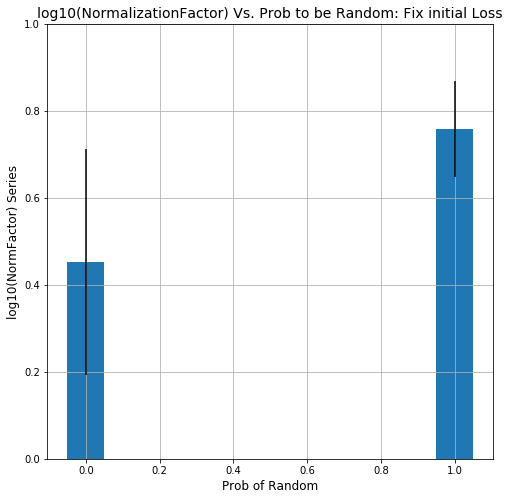

                        NML       ERM
Acc                0.785714  0.928571
Mean Loss (log10)  0.453642  0.175985
Std Loss (log10)   0.261005  0.714029


In [32]:

# Random probalility 0.0
files = ['../output/Random_Labels_results_20181010_171928/results_Random_Labels_20181010_171928.json']
results_dict_Random_0 = load_dict_from_file_list(files)
print('Random P=0.0: loaded %d keys' % len(results_dict_Random_0))

# Random probalility 1.0
files = ['../output/Random_Labels_results_20181010_171937/results_Random_Labels_20181010_171937.json'] 
results_dict_Random_1 = load_dict_from_file_list(files)
print('Random P=1.0: loaded %d keys' % len(results_dict_Random_1))

random_prob = [0.0, 1.0]

# Extract normalization factor
result_dict_list = [results_dict_Random_0, results_dict_Random_1]

# Extract the log normalization factor
mean_log_norm_factor_list = []
std_log_norm_factor_list = []
for results_dict in result_dict_list:
    _, norm_factor_list, _, _, _  = get_NML_log_loss_from_dict(results_dict)
    mean_log_norm_factor_list.append(np.log10(norm_factor_list).mean())
    std_log_norm_factor_list.append(np.log10(norm_factor_list).std())

loss, _, acc  = get_ERM_log_loss_from_dict(results_dict_Random_0)
print('log10(NormalizationFactor): Prob2beRandom={}={}'.format(random_prob, np.round(mean_log_norm_factor_list,3)))

# Plot normalization factor
plt.figure(figsize=(8,8))
plt.bar(random_prob,  mean_log_norm_factor_list, 0.1, yerr=std_log_norm_factor_list,  label='NML')
plt.ylabel('log10(NormFactor) Series', fontsize=12)
plt.xlabel('Prob of Random', fontsize=12)
plt.title('log10(NormalizationFactor) Vs. Prob to be Random: Fix initial Loss', fontsize=14)
plt.ylim([0,1])
# plt.xlim([0,1])
plt.grid()
plt.show()

# Plot preformance of NML and ERM
nml_loss, _, nml_acc, _, _  = get_NML_log_loss_from_dict(results_dict_Random_0)
erm_loss, erm_acc, _ = get_ERM_log_loss_from_dict(results_dict_Random_0)
# Print acc and mean loss
statistics = {'NML' : pd.Series([nml_acc,  np.mean(nml_loss), np.std(nml_loss)],
                                index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)']),
              'ERM' :pd.Series([erm_acc,  np.mean(erm_loss), np.std(erm_loss)],
                               index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)'])}
print(pd.DataFrame(statistics).to_string())

# hyper search for random

In [33]:
# hyper search

# Random probalility 0.0
files = ['../output/Random_Labels_results_20181011_144647/results_Random_Labels_20181011_144647.json']
results_dict_Random_0 = load_dict_from_file_list(files)
print('Random P=0.0: loaded %d keys' % len(results_dict_Random_0))

# Random probalility 1.0
files = ['../output/Random_Labels_results_20181011_144834/results_Random_Labels_20181011_144834.json'] 
results_dict_Random_1 = load_dict_from_file_list(files)
print('Random P=1.0: loaded %d keys' % len(results_dict_Random_1))

random_prob = [0.0, 1.0]

# Todo: to remove
_, norm_factor_list0, _, _, _  = get_NML_log_loss_from_dict(results_dict_Random_0)
_, norm_factor_list1, _, _, _  = get_NML_log_loss_from_dict(results_dict_Random_1)
print(np.log10(norm_factor_list0))
print()
print(np.log10(norm_factor_list1))


Random P=0.0: loaded 30 keys
Random P=1.0: loaded 30 keys
[0.96545481 0.47603669 0.77135632 0.28166787 0.77571735 0.50858488
 0.34421964 0.86246124 0.82904347 0.94581158 0.64181693 0.47664136
 0.77545905 0.88354048 0.77852637 0.75876406 0.48362908 0.89385203
 0.91868431 0.81305477 0.86350546 0.77195368 0.95039057 0.75906318
 0.79193954 0.94339691 0.88821757 0.89571024 0.83645452 0.94776699]

[0.99540368 0.80164056 0.94471751 0.83332685 0.99282934 0.97447911
 0.99812174 0.99610542 0.84291943 0.99155697 0.85203945 0.9561346
 0.97989165 0.6843806  0.94325049 0.8010225  0.89151025 0.90156379
 0.88528749 0.98864883 0.99083725 0.99568795 0.88926192 0.79341481
 0.8618982  0.98818298 0.95754835 0.96080499 0.89884872 0.88903267]


In [34]:
# with weight decay

# scp -r p2_cella:/home/kobibi/cifar_random/quick_and_less/exp_0/output/Random_Labels_results_20181011_162809 .
# scp -r p2_cella:/home/kobibi/cifar_random/quick_and_less/exp_1/output/Random_Labels_results_20181011_162815 .    

# Random probalility 0.0
files = ['../output/Random_Labels_results_20181011_162809/results_Random_Labels_20181011_162809.json']
results_dict_Random_0 = load_dict_from_file_list(files)
print('Random P=0.0: loaded %d keys' % len(results_dict_Random_0))

# Random probalility 1.0
files = ['../output/Random_Labels_results_20181011_162815/results_Random_Labels_20181011_162815.json'] 
results_dict_Random_1 = load_dict_from_file_list(files)
print('Random P=1.0: loaded %d keys' % len(results_dict_Random_1))

random_prob = [0.0, 1.0]


# Extract normalization factor
result_dict_list = [results_dict_Random_0, results_dict_Random_1]

# Extract the log normalization factor
mean_log_norm_factor_list = []
std_log_norm_factor_list = []
for results_dict in result_dict_list:
    _, norm_factor_list, _, _, _  = get_NML_log_loss_from_dict(results_dict)
    mean_log_norm_factor_list.append(np.log10(norm_factor_list).mean())
    std_log_norm_factor_list.append(np.log10(norm_factor_list).std())

loss, _, acc  = get_ERM_log_loss_from_dict(results_dict_Random_0)
print('log10(NormalizationFactor): Prob2beRandom={}={}'.format(random_prob, np.round(mean_log_norm_factor_list,3)))
# Plot preformance of NML and ERM
nml_loss, _, nml_acc, _, _  = get_NML_log_loss_from_dict(results_dict_Random_0)
erm_loss, erm_acc, _ = get_ERM_log_loss_from_dict(results_dict_Random_0)
# Print acc and mean loss
statistics = {'NML' : pd.Series([nml_acc,  np.mean(nml_loss), np.std(nml_loss)],
                                index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)']),
              'ERM' :pd.Series([erm_acc,  np.mean(erm_loss), np.std(erm_loss)],
                               index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)'])}
print(pd.DataFrame(statistics).to_string())


# Todo: to remove
_, norm_factor_list0, _, _, _  = get_NML_log_loss_from_dict(results_dict_Random_0)
_, norm_factor_list1, _, _, _  = get_NML_log_loss_from_dict(results_dict_Random_1)
print(np.log10(norm_factor_list0))
print()
print(np.log10(norm_factor_list1))


# same without weight decay
print()
print('No weight decay')
# scp -r p2_cella:/home/kobibi/cifar_random/quick_and_less/exp_0/output/Random_Labels_results_20181011_144647 .
# scp -r p2_cella:/home/kobibi/cifar_random/quick_and_less/exp_1/output/Random_Labels_results_20181011_144834 . 
    
    # Random probalility 0.0
files = ['../output/Random_Labels_results_20181011_144647/results_Random_Labels_20181011_144647.json']
results_dict_Random_0 = load_dict_from_file_list(files)
print('Random P=0.0: loaded %d keys' % len(results_dict_Random_0))

# Random probalility 1.0
files = ['../output/Random_Labels_results_20181011_144834/results_Random_Labels_20181011_144834.json'] 
results_dict_Random_1 = load_dict_from_file_list(files)
print('Random P=1.0: loaded %d keys' % len(results_dict_Random_1))

random_prob = [0.0, 1.0]


# Extract normalization factor
result_dict_list = [results_dict_Random_0, results_dict_Random_1]

# Extract the log normalization factor
mean_log_norm_factor_list = []
std_log_norm_factor_list = []
for results_dict in result_dict_list:
    _, norm_factor_list, _, _, _  = get_NML_log_loss_from_dict(results_dict)
    mean_log_norm_factor_list.append(np.log10(norm_factor_list).mean())
    std_log_norm_factor_list.append(np.log10(norm_factor_list).std())

loss, _, acc  = get_ERM_log_loss_from_dict(results_dict_Random_0)
print('log10(NormalizationFactor): Prob2beRandom={}={}'.format(random_prob, np.round(mean_log_norm_factor_list,3)))


# Plot preformance of NML and ERM
nml_loss, _, nml_acc, _, _  = get_NML_log_loss_from_dict(results_dict_Random_0)
erm_loss, erm_acc, _ = get_ERM_log_loss_from_dict(results_dict_Random_0)
# Print acc and mean loss
statistics = {'NML' : pd.Series([nml_acc,  np.mean(nml_loss), np.std(nml_loss)],
                                index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)']),
              'ERM' :pd.Series([erm_acc,  np.mean(erm_loss), np.std(erm_loss)],
                               index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)'])}
print(pd.DataFrame(statistics).to_string())
# Todo: to remove
_, norm_factor_list0, _, _, _  = get_NML_log_loss_from_dict(results_dict_Random_0)
_, norm_factor_list1, _, _, _  = get_NML_log_loss_from_dict(results_dict_Random_1)
print(np.log10(norm_factor_list0))
print()
print(np.log10(norm_factor_list1))


Random P=0.0: loaded 27 keys
Random P=1.0: loaded 27 keys
log10(NormalizationFactor): Prob2beRandom=[0.0, 1.0]=[0.676 0.833]
                        NML       ERM
Acc                0.814815  0.888889
Mean Loss (log10)  0.677290  0.433014
Std Loss (log10)   0.208779  1.502686
[0.91794856 0.41378416 0.76024856 0.29481426 0.75759415 0.40433843
 0.04592417 0.83133645 0.69628576 0.88687029 0.50736489 0.44946881
 0.69835685 0.75734742 0.67924884 0.70307633 0.46655223 0.87419168
 0.88640437 0.7554023  0.74393031 0.71271947 0.84640117 0.79244016
 0.78807524 0.67156207 0.91344482]

[0.96378911 0.67715062 0.86605668 0.78737155 0.97262729 0.88027282
 0.94173763 0.96842652 0.81665237 0.95598267 0.69310097 0.94003531
 0.85280039 0.57490988 0.85932347 0.66306985 0.80383382 0.86701934
 0.8242589  0.93622102 0.49537206 0.7552753  0.93173224 0.927106
 0.88990769 0.81511516 0.82672348]

No weight decay
Random P=0.0: loaded 30 keys
Random P=1.0: loaded 30 keys
log10(NormalizationFactor): Prob2beRandom=[

# Training set subset

In [35]:
# #------
# # NML training set subset: training the model with reduce training set size

# # training set size 100
# files = ['../output/NML_trainset_subset_results_20180922_120302/results_NML_trainset_subset_20180922_120302.json'] # 0-99
# results_dict_trainingset_subset_0 = load_dict_from_file_list(files)
# print('trainingset_subset_100: loaded %d keys' % len(results_dict_trainingset_subset_0))

# # training set size 300
# files = ['../output/NML_trainset_subset_results_20180922_120325/results_NML_trainset_subset_20180922_120325.json'] # 0-99
# results_dict_trainingset_subset_1 = load_dict_from_file_list(files)
# print('trainingset_subset_300: loaded %d keys' % len(results_dict_trainingset_subset_1))

# # training set size 1,000
# files = ['../output/NML_trainset_subset_results_20180922_120401/results_NML_trainset_subset_20180922_120401.json'] # 0-99
# results_dict_trainingset_subset_2 = load_dict_from_file_list(files)
# print('trainingset_subset_1,000: loaded %d keys' % len(results_dict_trainingset_subset_2))

# # training set size 3,000
# files = ['../output/NML_trainset_subset_results_20180922_120758/results_NML_trainset_subset_20180922_120758.json'] # 0-99
# results_dict_trainingset_subset_3 = load_dict_from_file_list(files)
# print('trainingset_subset_3,000: loaded %d keys' % len(results_dict_trainingset_subset_3))

# # training set size 10,000
# files = ['../output/NML_trainset_subset_results_20180922_120524/results_NML_trainset_subset_20180922_120524.json'] # 0-99
# results_dict_trainingset_subset_4 = load_dict_from_file_list(files)
# print('trainingset_subset_10,000: loaded %d keys' % len(results_dict_trainingset_subset_4))

# # training set size 30,000
# files = ['../output/NML_trainset_subset_results_20180922_120521/results_NML_trainset_subset_20180922_120521.json'] # 0-99
# results_dict_trainingset_subset_5 = load_dict_from_file_list(files)
# print('trainingset_subset_30,000: loaded %d keys' % len(results_dict_trainingset_subset_5))

# # training set size 50,000
# files = ['../output/NML_trainset_subset_results_20180922_120421/results_NML_trainset_subset_20180922_120421.json'] # 0-99
# results_dict_trainingset_subset_6 = load_dict_from_file_list(files)
# print('trainingset_subset_50,000: loaded %d keys' % len(results_dict_trainingset_subset_6))

# trainset_size = [100, 300, 1000, 3000, 10000, 30000, 50000]
      
#------
# NML training set subset: training the model with reduce training set size: adjust sgd update

# training set size 100
files = ['../output/NML_trainset_subset_results_20180930_090805/results_NML_trainset_subset_20180930_090805.json'] # 0-99
results_dict_trainingset_subset_0 = load_dict_from_file_list(files)
print('trainingset_subset_100: loaded %d keys' % len(results_dict_trainingset_subset_0))

# training set size 500
files = ['../output/NML_trainset_subset_results_20180930_090815/results_NML_trainset_subset_20180930_090815.json'] # 0-99
results_dict_trainingset_subset_1 = load_dict_from_file_list(files)
print('trainingset_subset_500: loaded %d keys' % len(results_dict_trainingset_subset_1))

# training set size 1,000
files = ['../output/NML_trainset_subset_results_20180930_090837/results_NML_trainset_subset_20180930_090837.json'] # 0-99
results_dict_trainingset_subset_2 = load_dict_from_file_list(files)
print('trainingset_subset_1,000: loaded %d keys' % len(results_dict_trainingset_subset_2))

# training set size 5,000
files = ['../output/NML_trainset_subset_results_20180930_090840/results_NML_trainset_subset_20180930_090840.json'] # 0-99
results_dict_trainingset_subset_3 = load_dict_from_file_list(files)
print('trainingset_subset_5,000: loaded %d keys' % len(results_dict_trainingset_subset_3))

# training set size 10,000
files = ['../output/NML_trainset_subset_results_20180930_090905/results_NML_trainset_subset_20180930_090905.json'] # 0-99
results_dict_trainingset_subset_4 = load_dict_from_file_list(files)
print('trainingset_subset_10,000: loaded %d keys' % len(results_dict_trainingset_subset_4))

# training set size 12500
files = ['../output/NML_trainset_subset_results_20180930_090907/results_NML_trainset_subset_20180930_090907.json'] # 0-99
results_dict_trainingset_subset_5 = load_dict_from_file_list(files)
print('trainingset_subset_12,500: loaded %d keys' % len(results_dict_trainingset_subset_5))

# training set size 25,000
files = ['../output/NML_trainset_subset_results_20180930_090908/results_NML_trainset_subset_20180930_090908.json'] # 0-99
results_dict_trainingset_subset_6 = load_dict_from_file_list(files)
print('trainingset_subset_25,000: loaded %d keys' % len(results_dict_trainingset_subset_6))

# training set size 50,000
files = ['../output/NML_trainset_subset_results_20180930_090911/results_NML_trainset_subset_20180930_090911.json'] # 0-99
results_dict_trainingset_subset_7 = load_dict_from_file_list(files)
print('trainingset_subset_50,000: loaded %d keys' % len(results_dict_trainingset_subset_7))

trainset_size = [100, 500, 1000, 5000, 10000, 12500, 25000, 50000]

trainingset_subset_100: loaded 87 keys
trainingset_subset_500: loaded 86 keys
trainingset_subset_1,000: loaded 88 keys
trainingset_subset_5,000: loaded 87 keys
trainingset_subset_10,000: loaded 86 keys
trainingset_subset_12,500: loaded 84 keys
trainingset_subset_25,000: loaded 86 keys
trainingset_subset_50,000: loaded 84 keys


In [36]:
# Extract ormalization factor
result_dict_list = [results_dict_trainingset_subset_0, results_dict_trainingset_subset_1, 
                    results_dict_trainingset_subset_2, results_dict_trainingset_subset_3,
                    results_dict_trainingset_subset_4, results_dict_trainingset_subset_5, 
                    results_dict_trainingset_subset_6, results_dict_trainingset_subset_7]

# Extract the log normalization factor
mean_log_norm_factor_list = []
std_log_norm_factor_list = []
nml_mean_loss_list = []
nml_std_loss_list = []
nml_acc_list = []
for results_dict in result_dict_list:
    nml_loss, norm_factor_list, nml_acc, _, _  = get_NML_log_loss_from_dict(results_dict)
    mean_log_norm_factor_list.append(np.log10(norm_factor_list).mean())
    std_log_norm_factor_list.append(np.log10(norm_factor_list).std())
    nml_mean_loss_list.append(np.mean(nml_loss))
    nml_std_loss_list.append(np.std(nml_loss))
    nml_acc_list.append(nml_acc)
print('log10(NormalizationFactor): SubsetSize={}={}'.format(random_prob, np.round(mean_log_norm_factor_list,3)))

log10(NormalizationFactor): SubsetSize=[0.0, 1.0]=[0.413 0.882 0.324 0.149 0.606 0.433 0.572 0.096]


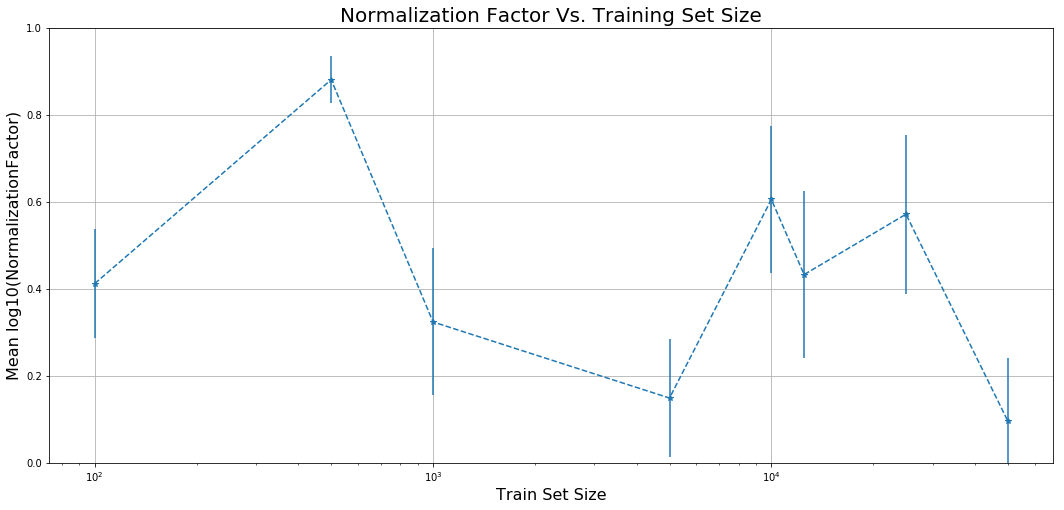

In [37]:
# Plot
plt.figure(figsize=(18,8))
plt.errorbar(trainset_size, mean_log_norm_factor_list, fmt='--*', yerr=std_log_norm_factor_list)
plt.xlabel('Train Set Size', fontsize=16)
plt.ylabel('Mean log10(NormalizationFactor)', fontsize=16)
plt.ylim([0, 1])
plt.xscale('log')
plt.title('Normalization Factor Vs. Training Set Size', fontsize=20)
plt.grid()
plt.show()

In [38]:
# Extract erm preformance
erm_mean_loss_list = []
erm_std_loss_list = []
erm_acc_list = []
for result_dict in result_dict_list:
    erm_loss, erm_acc, _ = get_ERM_log_loss_from_dict(result_dict)
    erm_mean_loss_list.append(np.mean(erm_loss))
    erm_std_loss_list.append(np.std(erm_loss))
    erm_acc_list.append(erm_acc)

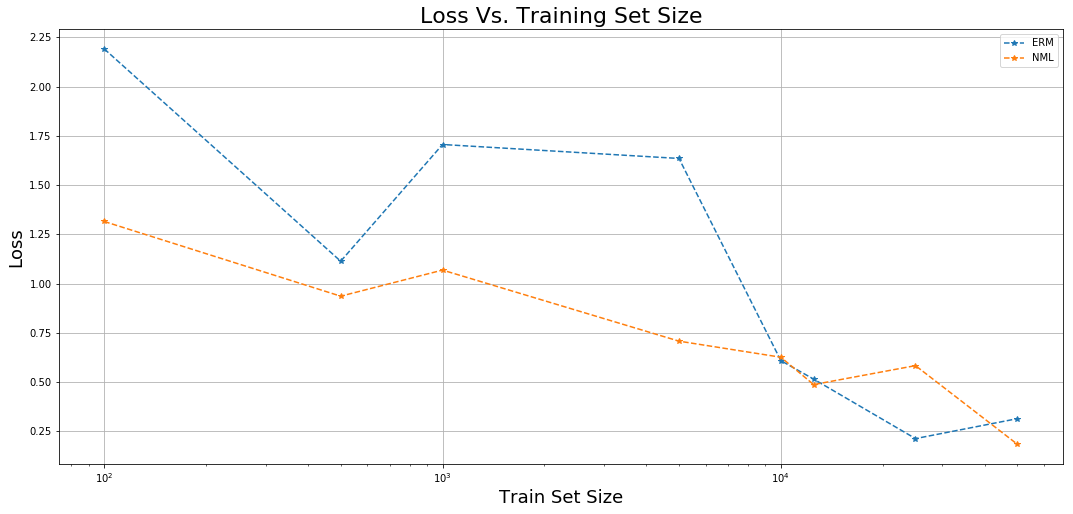

In [39]:
# Plot ERM vs NML Loss
plt.figure(figsize=(18,8))
plt.plot(trainset_size,  erm_mean_loss_list, '--*', label='ERM') # yerr=erm_std_loss_list, fmt='--*',  label='ERM')
plt.plot(trainset_size,  nml_mean_loss_list, '--*', label='NML')
plt.xlabel('Train Set Size', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xscale('log')
plt.title('Loss Vs. Training Set Size', fontsize=22)
plt.grid()
plt.legend()
plt.show()

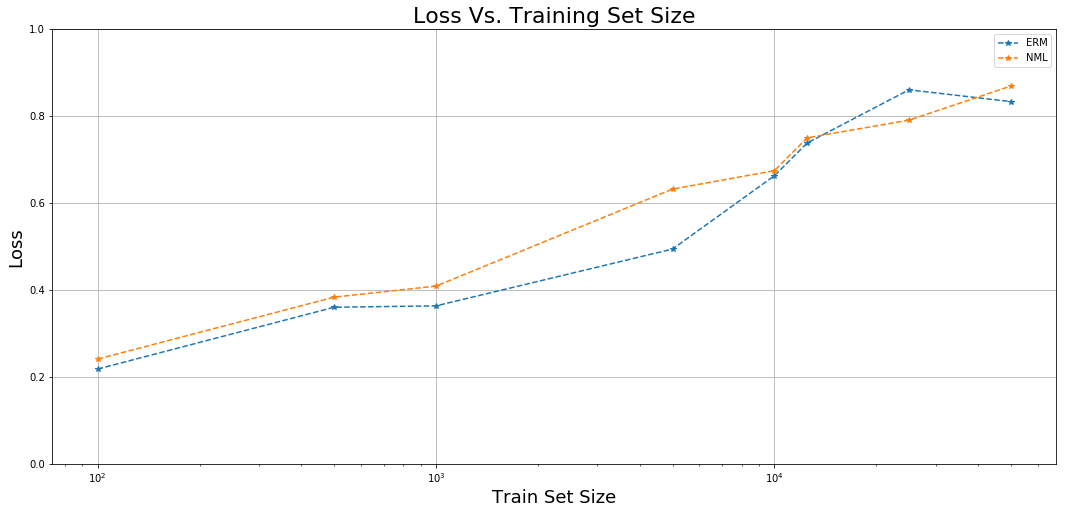

In [40]:
# Plot ERM vs NML Acc
plt.figure(figsize=(18,8))
plt.plot(trainset_size,  erm_acc_list, '--*', label='ERM') # yerr=erm_std_loss_list, fmt='--*',  label='ERM')
plt.plot(trainset_size,  nml_acc_list, '--*', label='NML')
plt.xlabel('Train Set Size', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xscale('log')
plt.ylim([0,1])
plt.title('Loss Vs. Training Set Size', fontsize=22)
plt.grid()
plt.legend()
plt.show()

# Try to train only last layer

In [49]:
# UN Freeze layer 5,6
files = ['../output/NML_results_20181022_113213/results_NML_20181022_113213.json', # 0-199
        '../output/NML_results_20181023_091440/results_NML_20181023_091440.json'] # 200-399
results_dict_freeze = load_dict_from_file_list(files)
print('results_dict_freeze: loaded %d keys' % len(results_dict_freeze))


# Plot preformance of NML and ERM
nml_loss, norm_factor, nml_acc, is_correct_NML_list, test_sample_idx_list  = get_NML_log_loss_from_dict(results_dict_freeze)
erm_loss, erm_acc, is_correct_ERM_list = get_ERM_log_loss_from_dict(results_dict_freeze)
loss_Jinni_list, acc_Jinni = get_jinni_log_loss_from_dict(results_dict_freeze)

# Print acc and mean loss
statistics = {'Jinni': pd.Series([acc_Jinni,  np.mean(loss_Jinni_list), np.std(loss_Jinni_list)], 
                                 index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)']),
              'NML' : pd.Series([nml_acc,  np.mean(nml_loss), np.std(nml_loss)],
                                index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)']),
              'ERM' :pd.Series([erm_acc,  np.mean(erm_loss), np.std(erm_loss)],
                               index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)'])}
print(pd.DataFrame(statistics).to_string())

results_dict_freeze: loaded 173 keys
                      Jinni       NML       ERM
Acc                0.988439  0.947977  0.930636
Mean Loss (log10)  0.013161  0.122979  0.080344
Std Loss (log10)   0.088087  0.195031  0.403329


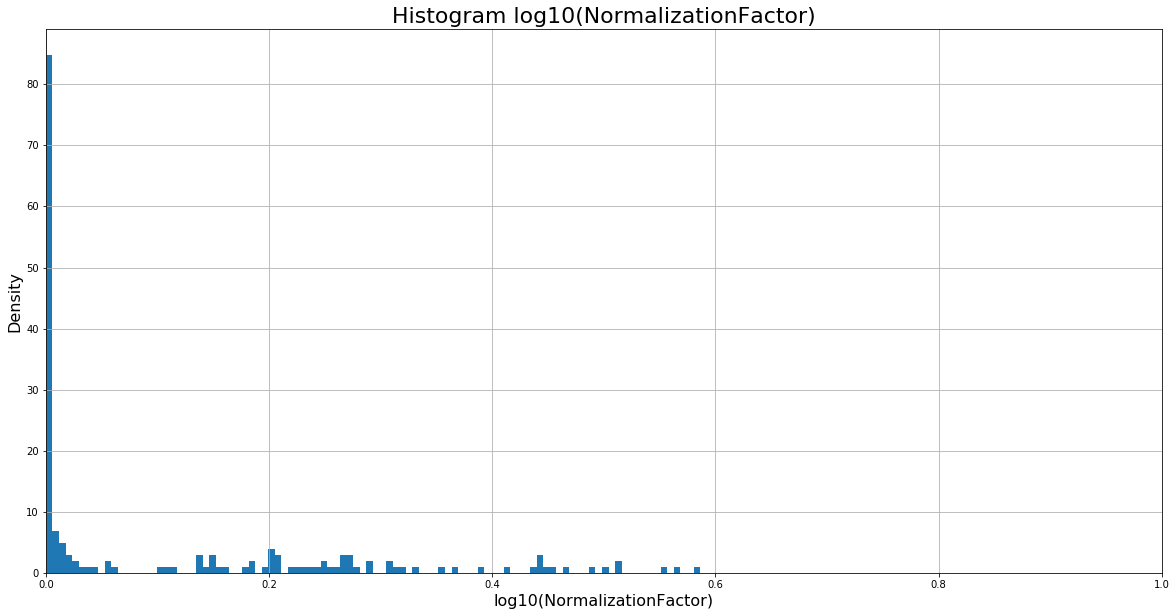

In [48]:
# Plot
plt.figure(figsize=(20,10))
plt.hist(np.log10(norm_factor), alpha=1, density=True, label='CIFAR 10 Images', bins=100)
plt.xlim([-0.0001,1])
plt.title('Histogram log10(NormalizationFactor)', fontsize=22)
plt.ylabel('Density', fontsize=16)
plt.xlabel('log10(NormalizationFactor)', fontsize=16)
plt.grid()
plt.show()

In [76]:
# Check when erm and nml are not agree
disagree = np.array(is_correct_NML_list) != np.array(is_correct_ERM_list) 
disagree = np.logical_not(np.logical_and(np.array(is_correct_NML_list), np.array(is_correct_ERM_list)))
disagree_idxes = np.array(test_sample_idx_list)[disagree==True].astype(np.int).tolist()
print(disagree_idxes)

[112, 12, 35, 52, 58, 59, 61, 95, 213, 223, 224, 226, 232]


Files already downloaded and verified
Files already downloaded and verified


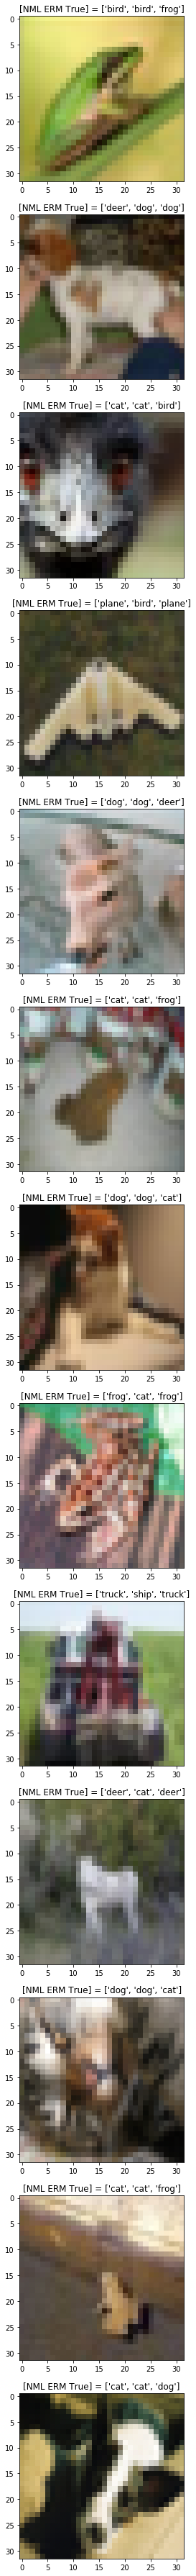

In [102]:
# Given a dict an idx, visualize ERM and NMl with prob of each. along with ground truth

# Inputs
results_dict =  results_dict_freeze
dict_idxes = disagree_idxes # [245, 246]


# Initialzie dataset and plots
fig = plt.figure(figsize=(20, 5*len(dict_idxes)))
trainloader, testloader, classes =  create_cifar10_dataloaders('../data', 1, 1)

# Loop on dict  idxes
for iter_idx, dict_idx in enumerate(dict_idxes):
    prob_nml, true_label, predicted_label, prob_erm =  extract_probabilities_list( results_dict[str(dict_idx)])
    prob_nml, normalization_factor= execute_normalize_prob(prob_nml)

    # Extract class names
    class_predict_nml = classes[np.argmax(prob_nml)]
    class_predict_erm = classes[np.argmax(prob_erm)]
    class_predict_gt = classes[true_label]
    # Extract image
    data = testloader.dataset.test_data[dict_idx]

    # Plot the image
    ax = fig.add_subplot(len(dict_idxes),1,iter_idx + 1)
    ax.imshow(data)
    ax.set_title('[NML ERM True] = {}'.format([class_predict_nml, class_predict_erm, class_predict_gt]) )

plt.show()